# Feature Engineering para Señales de ECG

## Resumen Ejecutivo

Este notebook implementa un sistema completo de **ingeniería de características** para señales de electrocardiograma (ECG). El objetivo principal es extraer características relevantes que permitan distinguir entre diferentes tipos de arritmias cardíacas para su posterior uso en modelos de machine learning.

### Objetivos:
1. **Cargar y explorar** el dataset de señales ECG preprocesadas
2. **Extraer características estadísticas básicas** de las señales
3. **Implementar técnicas de reducción de dimensionalidad** (PCA, t-SNE, UMAP)
4. **Desarrollar un sistema de extracción de características avanzadas** usando NeuroKit2
5. **Visualizar y analizar** la separabilidad de las clases en espacios reducidos

### Estructura del Dataset:
- **NSR**: Normal Sinus Rhythm (ritmo sinusal normal)
- **APB**: Atrial Premature Beat (latido auricular prematuro)
- **AFL**: Atrial Flutter (flutter auricular)
- **AFIB**: Atrial Fibrillation (fibrilación auricular)
- **SVTA**: Supraventricular Tachyarrhythmia (taquiarritmia supraventricular)
- **WPW**: Wolff-Parkinson-White syndrome
- **PVC**: Premature Ventricular Contraction (contracción ventricular prematura)
- **Bigeminy**: Bigeminismo ventricular
- **Trigeminy**: Trigeminismo ventricular
- **VT**: Ventricular Tachycardia (taquicardia ventricular)
- **IVR**: Idioventricular Rhythm (ritmo idioventricular)
- **VFL**: Ventricular Flutter (flutter ventricular)
- **Fusion**: Latidos de fusión
- **LBBBB**: Left Bundle Branch Block (bloqueo de rama izquierda)
- **RBBBB**: Right Bundle Branch Block (bloqueo de rama derecha)
- **SDHB**: Second Degree Heart Block (bloqueo cardíaco de segundo grado)
- **PR**: Paced Rhythm (ritmo marcapasos)

---

## 1. Configuración Inicial y Librerías

En esta sección se importan todas las librerías necesarias para el análisis:

- **Numpy/Pandas**: Manipulación de datos y cálculos numéricos
- **Matplotlib/Seaborn**: Visualización de datos
- **Scikit-learn**: Algoritmos de machine learning y preprocesamiento
- **NeuroKit2**: Librería especializada en procesamiento de señales fisiológicas (ECG, EEG, etc.)

In [1]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
!dir

 El volumen de la unidad D no tiene etiqueta.
 El n�mero de serie del volumen es: 08C4-45BE

 Directorio de d:\CODES\Tesis-MIA-UNI\notebooks

30/10/2025  05:37 p.m.    <DIR>          .
30/10/2025  02:50 p.m.    <DIR>          ..
30/10/2025  02:50 p.m.    <DIR>          .ipynb_checkpoints
30/10/2025  02:50 p.m.         2,917,605 1_generacion_DB.ipynb
30/10/2025  06:36 p.m.         1,026,256 2_1_Feature_Engineering copy.ipynb
30/10/2025  05:35 p.m.         1,986,436 2_1_Feature_Engineering.ipynb
30/10/2025  02:50 p.m.         3,072,312 2_preprocesamiento_DB.ipynb
30/10/2025  02:50 p.m.           538,097 3_Procesamiento.ipynb
30/10/2025  02:50 p.m.         2,006,870 4_GAN_1D.ipynb
30/10/2025  02:50 p.m.       268,009,099 data.csv
30/10/2025  02:50 p.m.    <DIR>          ECG_DATASET
30/10/2025  02:50 p.m.    <DIR>          ECG_DATASET_V2
30/10/2025  02:50 p.m.    <DIR>          RAW_ECG_DATASET
30/10/2025  02:50 p.m.    <DIR>          _OLD
               7 archivos    279,556,675 bytes
    

In [3]:
path = os.path.join("ECG_DATASET", "dataset_ekg.pkl")
print(path)
print(os.path.exists(path))
print(os.listdir("ECG_DATASET"))

ECG_DATASET\dataset_ekg.pkl
True
['dataset_ecg.zip', 'dataset_ekg.pkl', 'dict_labels.pkl']


## 2. Carga y Exploración del Dataset

### 2.1 Verificación de Archivos
Primero verificamos la estructura del directorio y la existencia del archivo de datos preprocesados.

In [4]:
import pickle

with open(path, 'rb') as file:
    data = pickle.load(file)
    print("Data loaded successfully.")

data

Data loaded successfully.


{'NSR': array([[-0.06451476, -0.05951476, -0.02951476, ...,  0.13548524,
          0.13048524,  0.11548524],
        [ 0.24548524,  0.25048524,  0.24048524, ...,  0.34048524,
          0.33548524,  0.31548524],
        [ 0.13048524,  0.12548524,  0.11048524, ..., -0.20451476,
         -0.20451476, -0.20451476],
        ...,
        [-0.46451476, -0.46451476, -0.46451476, ..., -0.59451476,
         -0.58951476, -0.58951476],
        [-0.53451476, -0.51451476, -0.53451476, ..., -0.51451476,
         -0.44451476, -0.40451476],
        [ 0.51548524,  0.50548524,  0.50548524, ...,  0.21048524,
          0.20048524,  0.18548524]], shape=(283, 3600)),
 'VT': array([[ 0.10787069,  0.08787069,  0.08787069, ...,  0.01287069,
         -0.00212931,  0.01787069],
        [-0.31212931, -0.29712931, -0.27212931, ...,  0.82787069,
          0.84787069,  0.86787069],
        [ 0.01287069,  0.00787069,  0.00287069, ...,  0.04787069,
          0.06787069,  0.10287069],
        ...,
        [ 0.17287069, 

### 2.2 Carga del Dataset Preprocesado
El dataset está almacenado en formato pickle y contiene señales de ECG organizadas por tipo de arritmia. Cada clase contiene múltiples señales temporales representando diferentes patrones cardíacos.

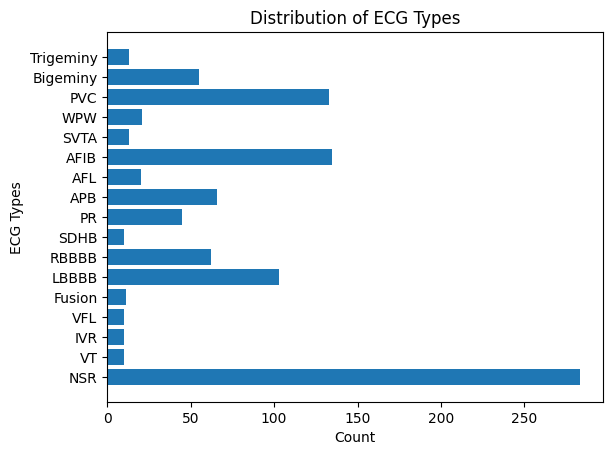

In [5]:
labels = list(data.keys())
counts = [j.shape[0] for j in data.values()]
plt.barh(labels, counts)
plt.xlabel('Count')
plt.ylabel('ECG Types')
plt.title('Distribution of ECG Types')
plt.show()

### 2.3 Análisis de Distribución de Clases
Visualizamos la distribución de muestras por cada tipo de arritmia para entender el balanceo del dataset. Esto es crucial para:
- Identificar clases desbalanceadas que puedan requerir técnicas especiales de muestreo
- Planificar estrategias de validación apropiadas
- Entender la representatividad de cada clase

## 3. Extracción de Características Estadísticas Básicas

### 3.1 Función de Extracción de Características
Implementamos una función que extrae características estadísticas fundamentales de las señales de ECG:
- **Medidas de tendencia central**: media, mediana
- **Medidas de dispersión**: desviación estándar, varianza, rango
- **Medidas de forma**: asimetría (skewness) y curtosis
- **Valores extremos**: mínimo, máximo, amplitud pico-pico

In [6]:
import pandas as pd

In [7]:
def statistics_extract_features(signal):
    features = {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'median': np.median(signal),
        'min': np.min(signal),
        'max': np.max(signal),
        'ptp': np.ptp(signal), # Peak-to-peak amplitude
        'variance': np.var(signal),
        'skewness': pd.Series(signal).skew(),
        'kurtosis': pd.Series(signal).kurtosis()
    }
    return features


### 3.2 Análisis Exploratorio: Ritmo Sinusal Normal (NSR)

Comenzamos el análisis con la clase **NSR** (Normal Sinus Rhythm) que representa el patrón cardíaco saludable. Esta clase sirve como referencia para comparar con las arritmias patológicas.

In [8]:
# Extract features for each class
data_NSR = data['NSR']
features_NSR = pd.DataFrame([statistics_extract_features(signal) for signal in data_NSR])

features_NSR.head()

,mean,std,median,min,max,ptp,variance,skewness,kurtosis
0,0.160284,0.228847,0.115485,-0.144515,1.705485,1.850,0.052371,3.593412,16.699166
1,0.270717,0.225989,0.235485,-0.494515,1.595485,2.090,0.051071,2.195015,11.268041
2,0.131302,0.266043,0.060485,-0.204515,1.845485,2.050,0.070779,3.475559,14.100811
3,-0.529288,0.337955,-0.604515,-0.959515,1.075485,2.035,0.114213,3.220420,10.432794
4,0.335085,0.299513,0.260485,0.110485,2.380485,2.270,0.089708,4.468361,22.112125


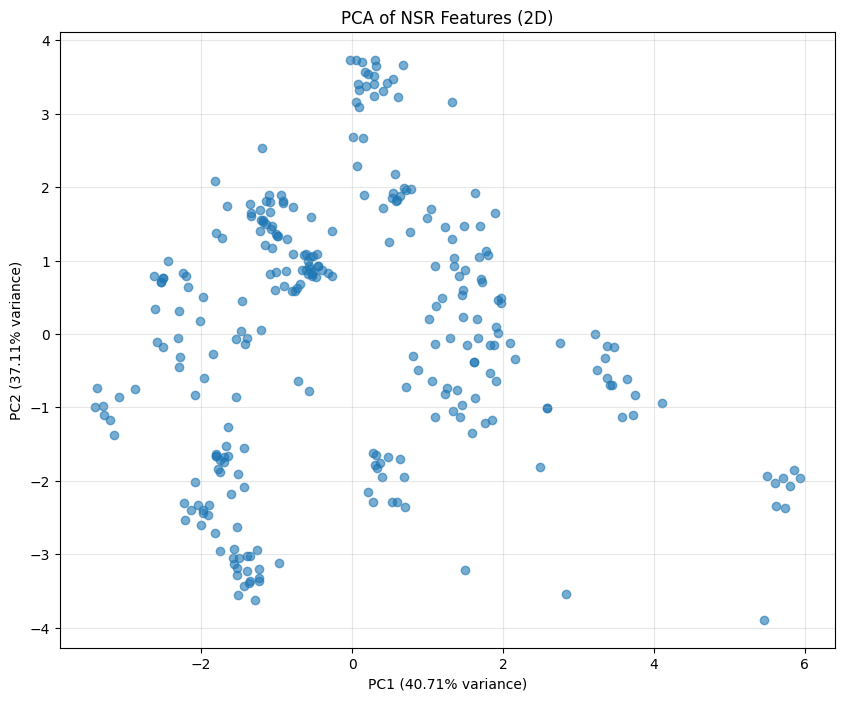

Total variance explained: 77.81%


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Normalize features_NSR with StandardScaler
scaler = StandardScaler()
features_NSR_scaled = scaler.fit_transform(features_NSR)

# Apply PCA with 2 components
pca = PCA(n_components=2)
features_NSR_pca = pca.fit_transform(features_NSR_scaled)

# Plot the 2D PCA results
plt.figure(figsize=(10, 8))
plt.scatter(features_NSR_pca[:, 0], features_NSR_pca[:, 1], alpha=0.6)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA of NSR Features (2D)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2%}")

### 3.3 Reducción de Dimensionalidad para NSR

Aplicamos técnicas de reducción de dimensionalidad para visualizar los patrones en las características extraídas:

#### 3.3.1 PCA (Análisis de Componentes Principales)
PCA encuentra las direcciones de máxima varianza en los datos, permitiendo reducir la dimensionalidad preservando la mayor cantidad de información posible.

  File "c:\Users\47470482\AppData\Local\anaconda3\envs\torch-env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "c:\Users\47470482\AppData\Local\anaconda3\envs\torch-env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\47470482\AppData\Local\anaconda3\envs\torch-env\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\47470482\AppData\Local\anaconda3\envs\torch-env\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
    

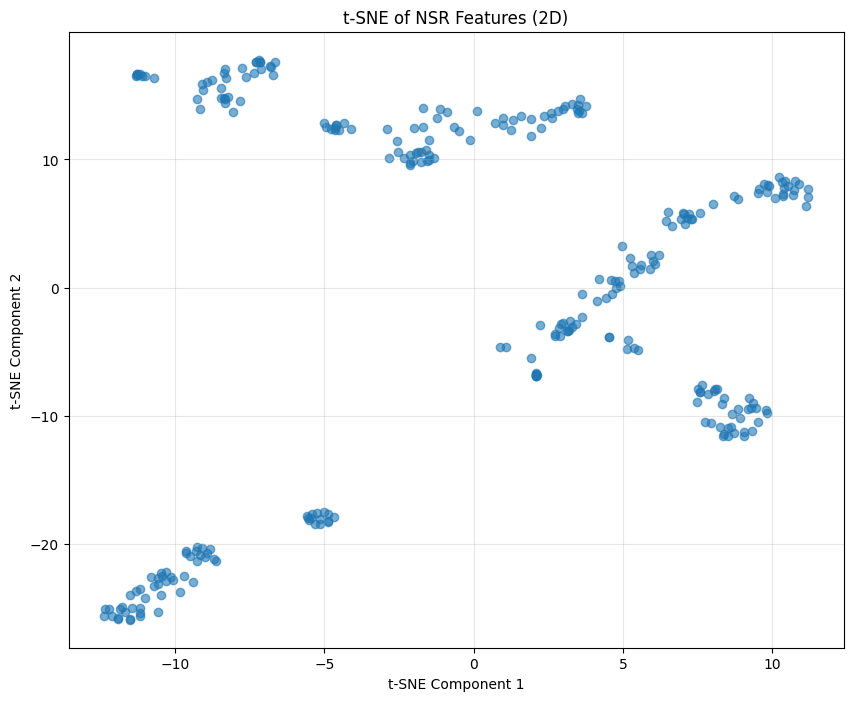

In [10]:
from sklearn.manifold import TSNE

# Apply t-SNE with 2 components
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
features_NSR_tsne = tsne.fit_transform(features_NSR_scaled)

# Plot the 2D t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(features_NSR_tsne[:, 0], features_NSR_tsne[:, 1], alpha=0.6)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of NSR Features (2D)')
plt.grid(True, alpha=0.3)
plt.show()

#### 3.3.2 t-SNE (t-Distributed Stochastic Neighbor Embedding)
t-SNE es especialmente efectivo para visualizar estructuras no lineales en los datos, preservando las relaciones locales entre puntos similares.

In [11]:
!pip install umap-learn -y



Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -y


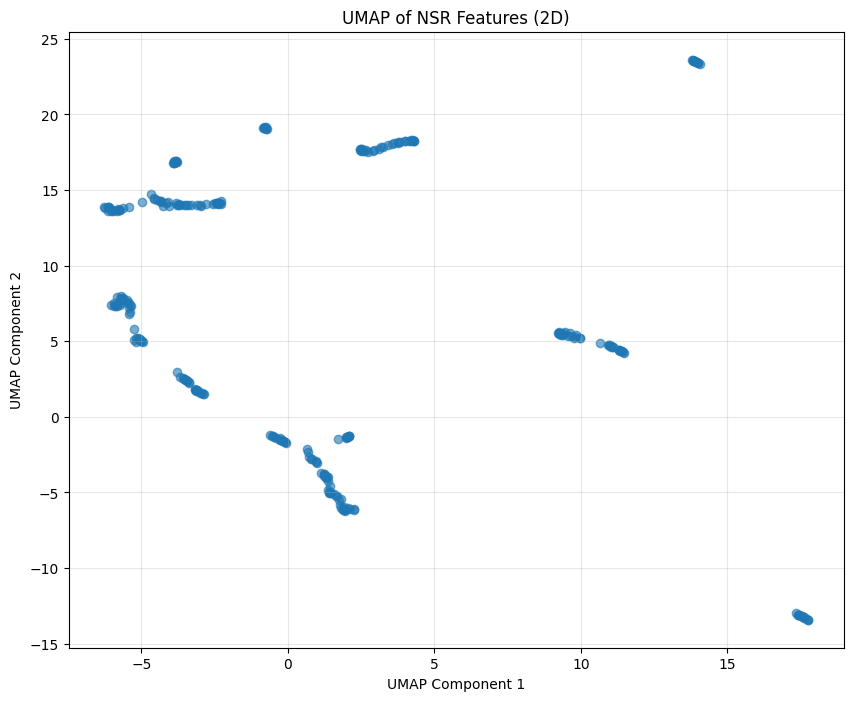

In [12]:
from umap.umap_ import UMAP

# Apply UMAP with 2 components
umap = UMAP(n_components=2, random_state=42)
features_NSR_umap = umap.fit_transform(features_NSR_scaled)

# Plot the 2D UMAP results
plt.figure(figsize=(10, 8))
plt.scatter(features_NSR_umap[:, 0], features_NSR_umap[:, 1], alpha=0.6)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP of NSR Features (2D)')
plt.grid(True, alpha=0.3)
plt.show()

#### 3.3.3 UMAP (Uniform Manifold Approximation and Projection)
UMAP combina las ventajas de PCA y t-SNE, preservando tanto la estructura global como local de los datos, siendo computacionalmente más eficiente que t-SNE.

Total samples: 1000
Classes: label
NSR          283
AFIB         135
PVC          133
LBBBB        103
APB           66
RBBBB         62
Bigeminy      55
PR            45
WPW           21
AFL           20
SVTA          13
Trigeminy     13
Fusion        11
SDHB          10
VT            10
IVR           10
VFL           10
Name: count, dtype: int64

Features table (first 10 rows):
       mean       std    median       min       max    ptp  variance  \
0  0.160284  0.228847  0.115485 -0.144515  1.705485  1.850  0.052371   
1  0.270717  0.225989  0.235485 -0.494515  1.595485  2.090  0.051071   
2  0.131302  0.266043  0.060485 -0.204515  1.845485  2.050  0.070779   
3 -0.529288  0.337955 -0.604515 -0.959515  1.075485  2.035  0.114213   
4  0.335085  0.299513  0.260485  0.110485  2.380485  2.270  0.089708   
5 -0.014426  0.279939  0.010485 -0.624515  1.545485  2.170  0.078366   
6  0.128769  0.258006  0.092985 -0.249515  2.000485  2.250  0.066567   
7 -0.229447  0.326075 -0.269515 -1.274515

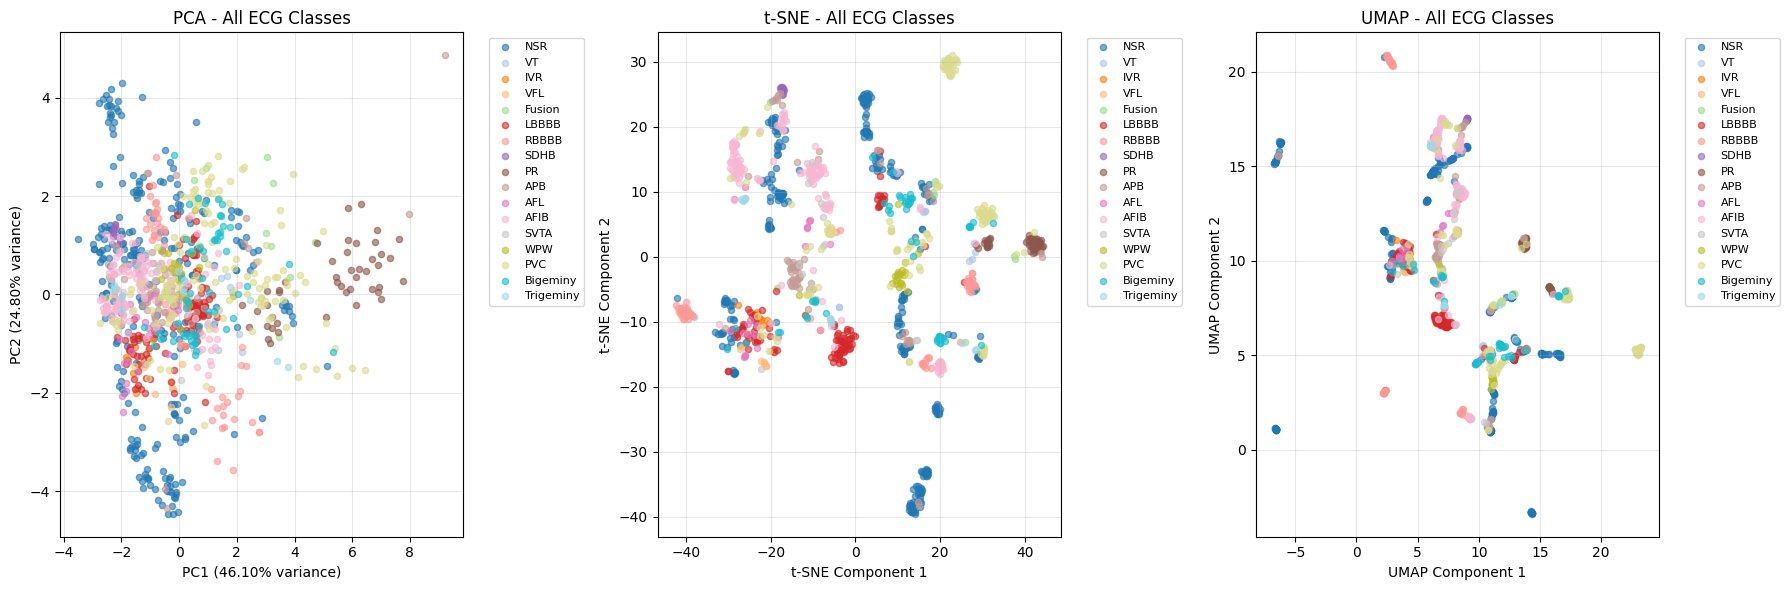


PCA total variance explained: 70.90%


In [13]:
# Create a comprehensive dataset with all features and labels
all_features = []
all_labels = []

# Extract features for all classes
for label in labels:
    class_data = data[label]
    class_features = [statistics_extract_features(signal) for signal in class_data]
    all_features.extend(class_features)
    all_labels.extend([label] * len(class_features))

# Create DataFrame with all features
features_df = pd.DataFrame(all_features)
features_df['label'] = all_labels

print(f"Total samples: {len(features_df)}")
print(f"Classes: {features_df['label'].value_counts()}")
print("\nFeatures table (first 10 rows):")
print(features_df.head(10))

# Separate features from labels for dimensionality reduction
X = features_df.drop('label', axis=1)
y = features_df['label']

# Normalize features
X_scaled = scaler.fit_transform(X)

# Apply dimensionality reduction techniques
print("\nApplying dimensionality reduction...")

# PCA
pca_full = PCA(n_components=2)
X_pca = pca_full.fit_transform(X_scaled)

# t-SNE
tsne_full = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne_full.fit_transform(X_scaled)

# UMAP
umap_full = UMAP(n_components=2, random_state=42)
X_umap = umap_full.fit_transform(X_scaled)

# Create visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Get unique labels and colors
unique_labels = y.unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

# PCA plot
for i, label in enumerate(unique_labels):
    mask = y == label
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=[colors[i]], label=label, alpha=0.6, s=20)
axes[0].set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]:.2%} variance)')
axes[0].set_title('PCA - All ECG Classes')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].grid(True, alpha=0.3)

# t-SNE plot
for i, label in enumerate(unique_labels):
    mask = y == label
    axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                   c=[colors[i]], label=label, alpha=0.6, s=20)
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].set_title('t-SNE - All ECG Classes')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].grid(True, alpha=0.3)

# UMAP plot
for i, label in enumerate(unique_labels):
    mask = y == label
    axes[2].scatter(X_umap[mask, 0], X_umap[mask, 1], 
                   c=[colors[i]], label=label, alpha=0.6, s=20)
axes[2].set_xlabel('UMAP Component 1')
axes[2].set_ylabel('UMAP Component 2')
axes[2].set_title('UMAP - All ECG Classes')
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPCA total variance explained: {sum(pca_full.explained_variance_ratio_):.2%}")

## 4. Análisis Completo del Dataset

### 4.1 Extracción de Características para Todas las Clases
Ahora aplicamos el proceso de extracción de características a todas las clases de arritmias disponibles en el dataset. Este análisis nos permitirá:

1. **Evaluar la separabilidad** entre diferentes tipos de arritmias
2. **Identificar patrones distintivos** en las características estadísticas
3. **Determinar la efectividad** de las técnicas de reducción de dimensionalidad para clasificación

Applying 3D dimensionality reduction...


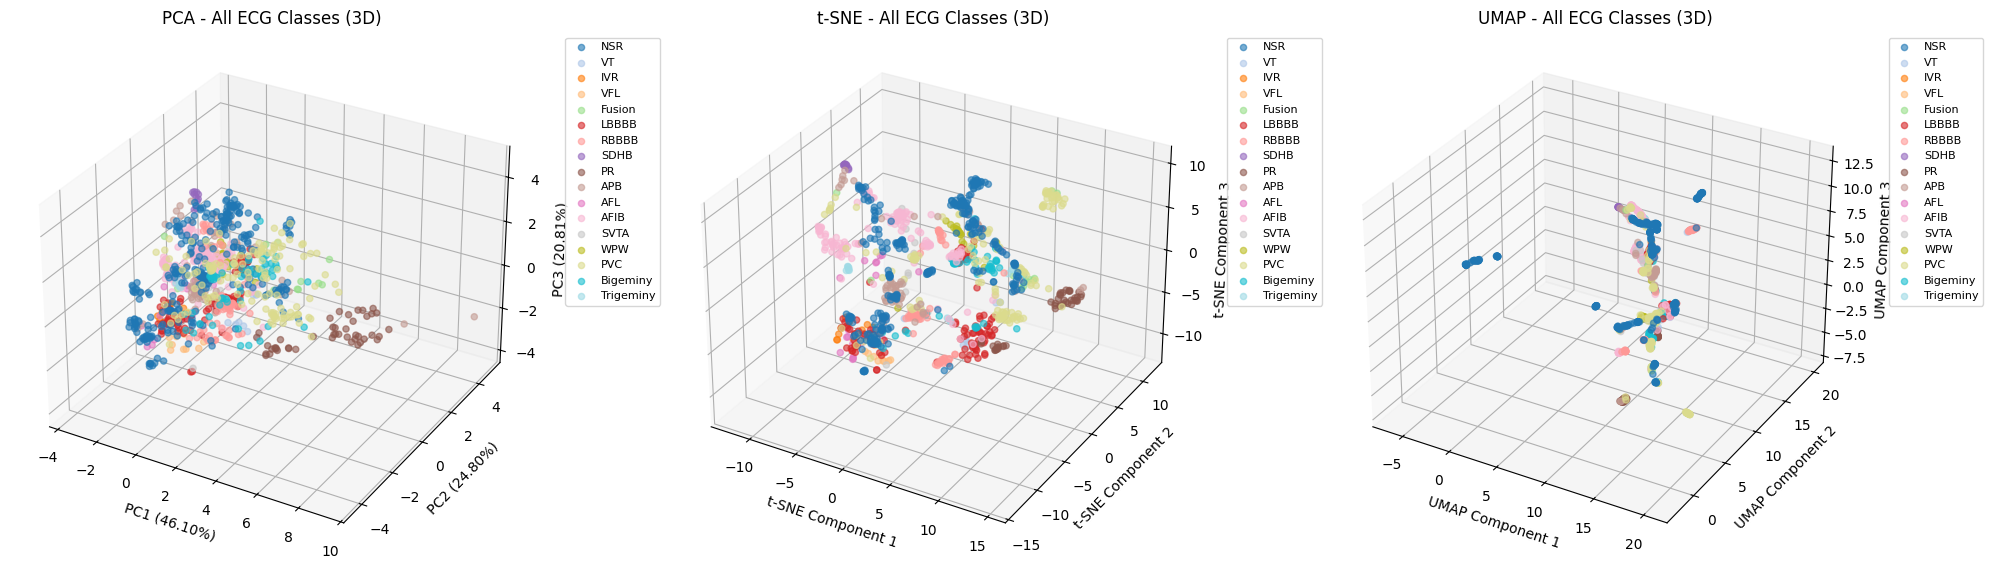


PCA total variance explained (3D): 91.71%
Individual components: PC1: 46.10%, PC2: 24.80%, PC3: 20.81%


In [14]:
from mpl_toolkits.mplot3d import Axes3D

# Apply dimensionality reduction techniques with 3 components
print("Applying 3D dimensionality reduction...")

# PCA with 3 components
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# t-SNE with 3 components
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
X_tsne_3d = tsne_3d.fit_transform(X_scaled)

# UMAP with 3 components
umap_3d = UMAP(n_components=3, random_state=42)
X_umap_3d = umap_3d.fit_transform(X_scaled)

# Create 3D visualizations
fig = plt.figure(figsize=(20, 6))

# Get unique labels and colors
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

# PCA 3D plot
ax1 = fig.add_subplot(131, projection='3d')
for i, label in enumerate(unique_labels):
    mask = y == label
    ax1.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2], 
               c=[colors[i]], label=label, alpha=0.6, s=20)
ax1.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})')
ax1.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})')
ax1.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})')
ax1.set_title('PCA - All ECG Classes (3D)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# t-SNE 3D plot
ax2 = fig.add_subplot(132, projection='3d')
for i, label in enumerate(unique_labels):
    mask = y == label
    ax2.scatter(X_tsne_3d[mask, 0], X_tsne_3d[mask, 1], X_tsne_3d[mask, 2], 
               c=[colors[i]], label=label, alpha=0.6, s=20)
ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')
ax2.set_zlabel('t-SNE Component 3')
ax2.set_title('t-SNE - All ECG Classes (3D)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# UMAP 3D plot
ax3 = fig.add_subplot(133, projection='3d')
for i, label in enumerate(unique_labels):
    mask = y == label
    ax3.scatter(X_umap_3d[mask, 0], X_umap_3d[mask, 1], X_umap_3d[mask, 2], 
               c=[colors[i]], label=label, alpha=0.6, s=20)
ax3.set_xlabel('UMAP Component 1')
ax3.set_ylabel('UMAP Component 2')
ax3.set_zlabel('UMAP Component 3')
ax3.set_title('UMAP - All ECG Classes (3D)')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

print(f"\nPCA total variance explained (3D): {sum(pca_3d.explained_variance_ratio_):.2%}")
print(f"Individual components: PC1: {pca_3d.explained_variance_ratio_[0]:.2%}, PC2: {pca_3d.explained_variance_ratio_[1]:.2%}, PC3: {pca_3d.explained_variance_ratio_[2]:.2%}")

### 4.2 Visualización Tridimensional
Para obtener una mejor comprensión de los patrones de separación entre clases, extendemos el análisis a **3 dimensiones**. Esto nos permite:

- **Capturar más varianza** en el caso de PCA
- **Revelar estructuras complejas** que no son visibles en 2D
- **Mejorar la interpretabilidad** de los agrupamientos naturales en los datos

## 5. Sistema Avanzado de Extracción de Características

### 5.1 Implementación con NeuroKit2

Las características estadísticas básicas proporcionan información limitada sobre los patrones complejos presentes en las señales de ECG. Para capturar información más rica y clínicamente relevante, implementamos un **sistema avanzado de extracción de características** utilizando NeuroKit2.

#### Ventajas del Enfoque Avanzado:
- **Características fisiológicamente interpretables**: HRV, intervalos PR/QRS/QT, amplitudes de ondas P/R/T
- **Detección automática de eventos cardíacos**: Ondas P, complejos QRS, ondas T
- **Análisis de frecuencia especializado**: Bandas de frecuencia específicas para detectar arritmias
- **Métricas de entropía**: Para capturar la complejidad de las señales
- **Características específicas por patología**: Indicadores especializados para AF, flutter, PVC, etc.

#### Tipos de Características Extraídas:

1. **Características Generales**:
   - Frecuencia cardíaca y variabilidad (HRV)
   - Intervalos temporales (PR, QRS, QT, QTc)
   - Amplitudes de ondas (P, R, T, S)
   - Análisis espectral y entropía

2. **Características Específicas de Patrones**:
   - Regularidad del ritmo RR
   - Presencia de ondas P
   - Detección de ondas f (fibrilación auricular)
   - Patrones de periodicidad (bigeminismo, trigeminismo)

In [15]:
# ecg_features_neurokit_only.py
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Dict, Any
import neurokit2 as nk


# ---------- PSD bandpower using NeuroKit2 only ----------
def _bandpower_psd(x, fs, fmin, fmax):
    """Bandpower via nk.signal_psd (Welch under the hood)."""
    if len(x) < fs:
        return np.nan
    try:
        psd = nk.signal_psd(x, sampling_rate=fs, method="welch", min_frequency=0.0, max_frequency=fs/2)
        # psd is a DataFrame with columns ["Frequency", "Power"]
        f = psd["Frequency"].to_numpy()
        p = psd["Power"].to_numpy()
        sel = (f >= fmin) & (f <= fmax)
        if not np.any(sel):
            return np.nan
        # integrate with trapezoid rule (NumPy)
        return float(np.trapz(p[sel], f[sel]))
    except Exception:
        return np.nan


def _nanmean(x): return float(np.nanmean(x)) if np.size(x) else np.nan
def _nanstd(x):  return float(np.nanstd(x, ddof=1)) if np.size(x) > 1 else np.nan


@dataclass
class ECGFeatureExtractorNK:
    fs: float
    clean_method: str = "neurokit"
    delineate_method: str = "dwt"

    def process(self, ecg: np.ndarray) -> Dict[str, Any]:
        try:
            signals, info = nk.ecg_process(ecg, sampling_rate=self.fs, method=self.clean_method)
            cleaned = signals["ECG_Clean"].to_numpy()
            rpeaks = np.array(info["ECG_R_Peaks"], dtype=int)
            
            # Handle nk.ecg_delineate which returns (signals, waves) tuple
            try:
                delineate_signals, waves = nk.ecg_delineate(
                    cleaned, rpeaks=rpeaks, sampling_rate=self.fs, method=self.delineate_method
                )
                # waves is the dictionary we need
                delineate = waves
            except Exception as e:
                print(f"Warning: ECG delineation failed: {e}")
                delineate = {}
                
            return {"signals": signals, "info": info, "cleaned": cleaned, "rpeaks": rpeaks, "delineate": delineate}
        except Exception as e:
            # Return minimal structure if processing fails
            return {"signals": None, "info": None, "cleaned": ecg, "rpeaks": np.array([]), "delineate": {}}

    # -------- General ECG features --------
    def general_features(self, ecg: np.ndarray) -> Dict[str, Any]:
        P = self.process(ecg)
        fs, rpeaks, cleaned, delineate = self.fs, P["rpeaks"], P["cleaned"], P["delineate"]
        out: Dict[str, Any] = {}

        # HR, RR, simple HRV
        if rpeaks.size >= 2:
            rr = np.diff(rpeaks) / fs
            hr = 60.0 / rr
            diffs = np.diff(rr)
            out.update({
                "hr_mean_bpm": _nanmean(hr),
                "hr_std_bpm":  _nanstd(hr),
                "rr_mean_s":   _nanmean(rr),
                "rr_std_s":    _nanstd(rr),
                "rr_cv":       (_nanstd(rr) / _nanmean(rr)) if _nanmean(rr) and _nanmean(rr) > 0 else np.nan,
                "rmssd_s":     np.sqrt(_nanmean(diffs**2)) if diffs.size else np.nan,
                "sdnn_s":      _nanstd(rr),
                "pnn50_pct":   (np.mean(np.abs(diffs) > 0.05) * 100.0) if diffs.size else np.nan,
            })
        else:
            out.update({"hr_mean_bpm": np.nan, "hr_std_bpm": np.nan, "rr_mean_s": np.nan,
                        "rr_std_s": np.nan, "rr_cv": np.nan, "rmssd_s": np.nan,
                        "sdnn_s": np.nan, "pnn50_pct": np.nan})
        out.update({"n_beats": int(rpeaks.size), "duration_s": float(len(ecg) / fs)})

        # PR, QRS, QT, QTc from delineation - handle missing delineation gracefully
        QRS_on   = np.array(delineate.get("ECG_QRS_Onsets", []), dtype=float) if delineate else np.array([])
        QRS_off  = np.array(delineate.get("ECG_QRS_Offsets", []), dtype=float) if delineate else np.array([])
        T_off    = np.array(delineate.get("ECG_T_Offsets", []), dtype=float) if delineate else np.array([])
        P_peaks  = np.array(delineate.get("ECG_P_Peaks", []), dtype=float) if delineate else np.array([])

        # Remove NaN values from the arrays
        QRS_on = QRS_on[~np.isnan(QRS_on)] if QRS_on.size else np.array([])
        QRS_off = QRS_off[~np.isnan(QRS_off)] if QRS_off.size else np.array([])
        T_off = T_off[~np.isnan(T_off)] if T_off.size else np.array([])
        P_peaks = P_peaks[~np.isnan(P_peaks)] if P_peaks.size else np.array([])

        qrs_durs = (QRS_off - QRS_on) / fs if QRS_on.size and QRS_off.size and len(QRS_on) == len(QRS_off) else np.array([])
        qt_intervals = (T_off - QRS_on[:len(T_off)]) / fs if QRS_on.size and T_off.size else np.array([])

        # PR: pair previous P to next QRS within plausible window
        PRs = []
        if P_peaks.size and QRS_on.size:
            ip = 0
            for iq in range(len(QRS_on)):
                while ip + 1 < len(P_peaks) and P_peaks[ip + 1] < QRS_on[iq]:
                    ip += 1
                if ip < len(P_peaks):
                    dt = (QRS_on[iq] - P_peaks[ip]) / fs
                    if 0.06 <= dt <= 0.25:
                        PRs.append(dt)
        PRs = np.array(PRs, dtype=float)

        out.update({
            "pr_mean_s":  _nanmean(PRs),
            "pr_std_s":   _nanstd(PRs),
            "qrs_mean_s": _nanmean(qrs_durs),
            "qrs_std_s":  _nanstd(qrs_durs),
            "qt_mean_s":  _nanmean(qt_intervals),
            "qt_std_s":   _nanstd(qt_intervals),
        })

        rr_mean = out["rr_mean_s"]
        qt_mean = out["qt_mean_s"]
        if np.isfinite(qt_mean) and np.isfinite(rr_mean) and rr_mean > 0:
            out["qtc_bazett_s"] = qt_mean / np.sqrt(rr_mean)
            out["qtc_fridericia_s"] = qt_mean / (rr_mean ** (1/3))
        else:
            out["qtc_bazett_s"] = np.nan
            out["qtc_fridericia_s"] = np.nan

        # Amplitude proxies at detected peaks (P/R/T)
        if P["signals"] is not None:
            s = P["signals"]["ECG_Clean"].to_numpy()
            R_idx = rpeaks
            P_idx = P_peaks.astype(int) if P_peaks.size else np.array([], dtype=int)
            T_idx = np.array(delineate.get("ECG_T_Peaks", []), dtype=float) if delineate and delineate.get("ECG_T_Peaks") is not None else np.array([])
            # Remove NaN values and convert to int
            T_idx = T_idx[~np.isnan(T_idx)].astype(int) if T_idx.size else np.array([], dtype=int)
            
            def _pick(idx): return s[np.clip(idx, 0, len(s)-1)] if idx.size else np.array([])
            R_amp, P_amp, T_amp = _pick(R_idx), _pick(P_idx), _pick(T_idx)

            # S amplitude: min within 60 ms after R
            S_amp = []
            for r in R_idx:
                end = min(r + int(0.06 * fs), len(s))
                if r+1 < end:
                    S_amp.append(np.min(s[r+1:end]))
            S_amp = np.array(S_amp)
        else:
            R_amp, P_amp, T_amp, S_amp = np.array([]), np.array([]), np.array([]), np.array([])

        out.update({
            "p_amp_mean": _nanmean(P_amp),
            "r_amp_mean": _nanmean(R_amp),
            "t_amp_mean": _nanmean(T_amp),
            "rs_ratio_mean": (_nanmean(R_amp) / abs(_nanmean(S_amp))) if np.isfinite(_nanmean(S_amp)) and _nanmean(S_amp) != 0 else np.nan,
        })

        # Frequency domain & entropy (AF cues live here too)
        out.update({
            "power_0_5_40": _bandpower_psd(cleaned, fs, 0.5, 40.0),
            "power_4_9":    _bandpower_psd(cleaned, fs, 4.0, 9.0),
        })
        try:
            out["sampen"] = float(nk.entropy_sample(cleaned))
        except Exception:
            out["sampen"] = np.nan

        return out

    # -------- Lead II pattern-oriented cues --------
    def leadII_pattern_features(self, ecg: np.ndarray) -> Dict[str, Any]:
        P = self.process(ecg)
        fs, cleaned, rpeaks, delineate = self.fs, P["cleaned"], P["rpeaks"], P["delineate"]
        feats: Dict[str, Any] = {}

        # RR variability
        if rpeaks.size >= 3:
            rr = np.diff(rpeaks) / fs
            rr_cv = np.nanstd(rr, ddof=1) / np.nanmean(rr) if np.nanmean(rr) > 0 else np.nan
            rr_rmssd = np.sqrt(np.nanmean(np.diff(rr) ** 2)) if rr.size >= 2 else np.nan
        else:
            rr_cv, rr_rmssd = np.nan, np.nan

        # P presence ratio - handle missing delineation
        P_peaks = np.array(delineate.get("ECG_P_Peaks", []), dtype=float) if delineate else np.array([])
        QRS_on  = np.array(delineate.get("ECG_QRS_Onsets", []), dtype=float) if delineate else np.array([])
        QRS_off = np.array(delineate.get("ECG_QRS_Offsets", []), dtype=float) if delineate else np.array([])

        # Remove NaN values
        P_peaks = P_peaks[~np.isnan(P_peaks)] if P_peaks.size else np.array([])
        QRS_on = QRS_on[~np.isnan(QRS_on)] if QRS_on.size else np.array([])
        QRS_off = QRS_off[~np.isnan(QRS_off)] if QRS_off.size else np.array([])

        has_p = 0
        if P_peaks.size and QRS_on.size:
            ip = 0
            for iq in range(len(QRS_on)):
                while ip + 1 < len(P_peaks) and P_peaks[ip + 1] < QRS_on[iq]:
                    ip += 1
                if ip < len(P_peaks):
                    dt = (QRS_on[iq] - P_peaks[ip]) / fs
                    if 0.06 <= dt <= 0.25:
                        has_p += 1
        p_presence_ratio = (has_p / len(QRS_on)) if QRS_on.size else np.nan

        # AF f-wave energy ratio (4–9 vs 0.5–40 Hz) using NK PSD
        pow_4_9 = _bandpower_psd(cleaned, fs, 4.0, 9.0)
        pow_05_40 = _bandpower_psd(cleaned, fs, 0.5, 40.0)
        fwave_ratio = (pow_4_9 / pow_05_40) if (pow_05_40 and np.isfinite(pow_05_40) and pow_05_40 > 0) else np.nan

        feats.update({
            "nsr_rr_regular_cv": rr_cv,
            "nsr_p_presence_ratio": p_presence_ratio,
            "af_rr_irregularity_rmssd": rr_rmssd,
            "af_fwave_ratio_4_9_over_0_5_40": fwave_ratio,
        })

        # Atrial flutter sawtooth peakiness near ~5 Hz (relative band prominence)
        band_4_6 = _bandpower_psd(cleaned, fs, 4.0, 6.0)
        band_3_4 = _bandpower_psd(cleaned, fs, 3.0, 4.0)
        band_6_7 = _bandpower_psd(cleaned, fs, 6.0, 7.0)
        denom = (band_3_4 + band_6_7) if np.isfinite(band_3_4) and np.isfinite(band_6_7) else np.nan
        feats["aflutter_sawtooth_peakiness"] = (band_4_6 / denom) if denom and denom > 0 else np.nan

        # QRS width (BBB / PVC cue)
        qrs_dur = ((QRS_off - QRS_on) / fs) if (QRS_on.size and QRS_off.size and len(QRS_on) == len(QRS_off)) else np.array([])
        feats.update({
            "qrs_mean_s": _nanmean(qrs_dur),
            "qrs_wide_ratio_over_120ms": (np.mean(qrs_dur > 0.12) if qrs_dur.size else np.nan)
        })

        # Trigeminy heuristic: wide QRS + no preceding P in 60–250 ms; periodicity every 3rd beat
        pvc_flags = []
        if QRS_on.size:
            for i in range(QRS_on.size):
                is_wide = (qrs_dur[i] > 0.12) if i < len(qrs_dur) and np.isfinite(qrs_dur[i]) else False
                has_P = False
                if P_peaks.size:
                    j = np.searchsorted(P_peaks, QRS_on[i]) - 1
                    if j >= 0:
                        dt = (QRS_on[i] - P_peaks[j]) / fs
                        has_P = (0.06 <= dt <= 0.25)
                pvc_flags.append(bool(is_wide and not has_P))
        pvc_flags = np.array(pvc_flags, dtype=bool)

        trigeminy_score = np.nan
        if pvc_flags.size >= 6:
            expected = np.zeros_like(pvc_flags, dtype=bool)
            expected[2::3] = True
            mismatches = np.mean(pvc_flags != expected)
            trigeminy_score = 1.0 - mismatches

        feats.update({
            "trigeminy_periodicity_score_0to1": trigeminy_score,
            "pvc_ratio": float(np.mean(pvc_flags)) if pvc_flags.size else np.nan
        })

        return feats


# Convenience wrappers
def extract_general_features(ecg: np.ndarray, fs: float) -> Dict[str, Any]:
    return ECGFeatureExtractorNK(fs=fs).general_features(ecg)

def extract_leadII_pattern_features(ecg: np.ndarray, fs: float) -> Dict[str, Any]:
    return ECGFeatureExtractorNK(fs=fs).leadII_pattern_features(ecg)

In [16]:
#%pip install neurokit2 -q

# Generate more comprehensive features using the new extraction functions
print("Extracting comprehensive features for all classes...")

# Initialize lists to store features and labels
all_general_features = []
all_pattern_features = []
all_labels_comprehensive = []

# Set sampling frequency (assuming 360 Hz based on common ECG datasets)
fs = 360

# Extract features for each class using the new functions
for label in labels:
    print(f"Processing {label}...")
    class_data = data[label]
    
    for i, signal in enumerate(class_data):
        try:
            # Extract general ECG features
            general_feats = extract_general_features(signal, fs)
            
            # Extract Lead II pattern features
            pattern_feats = extract_leadII_pattern_features(signal, fs)
            
            # Combine all features
            combined_feats = {**general_feats, **pattern_feats}
            
            all_general_features.append(general_feats)
            all_pattern_features.append(pattern_feats)
            all_labels_comprehensive.append(label)
            
        except Exception as e:
            print(f"Error processing signal {i} from {label}: {e}")
            continue
    
    print(f"Completed {label}: {len([l for l in all_labels_comprehensive if l == label])} samples processed")



Extracting comprehensive features for all classes...
Processing NSR...
Completed NSR: 283 samples processed
Processing VT...
Completed VT: 10 samples processed
Processing IVR...
Completed IVR: 10 samples processed
Processing VFL...
Completed VFL: 10 samples processed
Processing Fusion...
Completed Fusion: 11 samples processed
Processing LBBBB...
Completed LBBBB: 103 samples processed
Processing RBBBB...
Completed RBBBB: 62 samples processed
Processing SDHB...
Completed SDHB: 10 samples processed
Processing PR...
Completed PR: 45 samples processed
Processing APB...
Completed APB: 66 samples processed
Processing AFL...
Completed AFL: 20 samples processed
Processing AFIB...
Completed AFIB: 135 samples processed
Processing SVTA...
Completed SVTA: 13 samples processed
Processing WPW...
Completed WPW: 21 samples processed
Processing PVC...
Completed PVC: 133 samples processed
Processing Bigeminy...
Completed Bigeminy: 55 samples processed
Processing Trigeminy...
Completed Trigeminy: 13 sampl

### 5.2 Aplicación del Sistema a Todo el Dataset

Aplicamos el sistema de extracción avanzada a todas las clases del dataset. Este proceso:

1. **Procesa cada señal individualmente** usando los algoritmos de NeuroKit2
2. **Extrae características generales y específicas** simultáneamente  
3. **Maneja errores de procesamiento** de manera robusta
4. **Genera un dataset enriquecido** con características clínicamente relevantes

**Nota**: Este proceso puede tomar varios minutos debido a la complejidad del análisis de cada señal.

In [17]:
if len(all_general_features) == 0:
    print("No features were extracted successfully. Please check the neurokit2 installation and feature extraction functions.")

In [18]:
# Fix for duplicate columns issue
general_df = pd.DataFrame(all_general_features)
pattern_df = pd.DataFrame(all_pattern_features)

# remove duplicate columns if any
#general_df2 = general_df.loc[:,~general_df.columns.duplicated()]
# Remove duplicate columns from pattern_df
duplicates = set(general_df.columns) & set(pattern_df.columns)
print(f"Removing duplicates: {duplicates}")
pattern_df = pattern_df.drop(columns=list(duplicates))

# Combine and add labels
final_df = pd.concat([general_df, pattern_df], axis=1)
final_df['label'] = all_labels_comprehensive

# Fill NaN values column by column (this avoids the pandas error)
for col in final_df.columns[:-1]:  # exclude 'label' column
    if final_df[col].dtype in ['float64', 'int64']:
        final_df[col] = final_df[col].fillna(final_df[col].median())

print(f"✅ SUCCESS: {final_df.shape[0]} samples, {final_df.shape[1]-1} features")
print(f"Classes distribution:")
print(final_df['label'].value_counts())

Removing duplicates: {'qrs_mean_s'}
✅ SUCCESS: 1000 samples, 33 features
Classes distribution:
label
NSR          283
AFIB         135
PVC          133
LBBBB        103
APB           66
RBBBB         62
Bigeminy      55
PR            45
WPW           21
AFL           20
SVTA          13
Trigeminy     13
Fusion        11
SDHB          10
VT            10
IVR           10
VFL           10
Name: count, dtype: int64


## 6. Construcción del Dataset Final

### 6.1 Consolidación de Características
Combinamos las características generales y específicas en un único DataFrame, resolviendo duplicados y agregando las etiquetas de clase correspondientes.

In [19]:
final_df.head()

,hr_mean_bpm,hr_std_bpm,rr_mean_s,rr_std_s,rr_cv,rmssd_s,sdnn_s,pnn50_pct,n_beats,duration_s,...,sampen,nsr_rr_regular_cv,nsr_p_presence_ratio,af_rr_irregularity_rmssd,af_fwave_ratio_4_9_over_0_5_40,aflutter_sawtooth_peakiness,qrs_wide_ratio_over_120ms,trigeminy_periodicity_score_0to1,pvc_ratio,label
0,55.594217,2.072857,1.080556,0.040062,0.037075,0.042815,0.040062,42.857143,9,10.0,...,NaN,0.037075,NaN,0.042815,0.374895,0.757103,NaN,NaN,NaN,NSR
1,95.582174,3.644154,0.628571,0.023732,0.037755,0.020915,0.023732,7.692308,15,10.0,...,NaN,0.037755,NaN,0.020915,0.302998,1.156143,NaN,NaN,NaN,NSR
2,63.848575,2.325837,0.940833,0.033870,0.036000,0.031522,0.033870,0.000000,11,10.0,...,NaN,0.036000,NaN,0.031522,0.426474,0.902774,NaN,NaN,NaN,NSR
3,87.747174,2.215079,0.684188,0.017398,0.025429,0.024243,0.017398,8.333333,14,10.0,...,NaN,0.025429,NaN,0.024243,0.539506,4.196736,NaN,NaN,NaN,NSR
4,51.250854,1.378099,1.171429,0.031086,0.026537,0.033812,0.031086,16.666667,8,10.0,...,NaN,0.026537,NaN,0.033812,0.403250,0.922551,NaN,NaN,NaN,NSR


In [20]:
# Remove columns with too many NaN values from final_df
# Calculate the percentage of NaN values for each column
nan_percentage = final_df.isnull().sum() / len(final_df) * 100

print("NaN percentage per column:")
print(nan_percentage.sort_values(ascending=False))

# Define threshold (e.g., remove columns with more than 50% NaN values)
threshold = 50
columns_to_drop = nan_percentage[nan_percentage > threshold].index.tolist()

print(f"\nColumns to drop (>{threshold}% NaN):")
print(columns_to_drop)

# Remove columns with high NaN percentage
final_df_cleaned = final_df.drop(columns=columns_to_drop)

print(f"\nOriginal shape: {final_df.shape}")
print(f"Cleaned shape: {final_df_cleaned.shape}")
print(f"Removed {len(columns_to_drop)} columns")

# Update final_df
final_df = final_df_cleaned

print(f"\nRemaining columns:")
print(list(final_df.columns))

NaN percentage per column:
qtc_bazett_s                        100.0
qtc_fridericia_s                    100.0
nsr_p_presence_ratio                100.0
pvc_ratio                           100.0
qt_std_s                            100.0
qt_mean_s                           100.0
qrs_std_s                           100.0
qrs_mean_s                          100.0
pr_std_s                            100.0
pr_mean_s                           100.0
sampen                              100.0
qrs_wide_ratio_over_120ms           100.0
trigeminy_periodicity_score_0to1    100.0
hr_mean_bpm                           0.0
hr_std_bpm                            0.0
duration_s                            0.0
pnn50_pct                             0.0
n_beats                               0.0
rr_mean_s                             0.0
rr_std_s                              0.0
rr_cv                                 0.0
rmssd_s                               0.0
sdnn_s                                0.0
p_amp_m

### 6.2 Limpieza de Datos: Manejo de Valores Faltantes

Un paso crítico en el preprocesamiento es identificar y manejar adecuadamente los valores NaN (Not a Number) que pueden surgir durante la extracción de características debido a:

- **Señales de baja calidad** que no permiten detección confiable de eventos
- **Arritmias severas** donde algunos parámetros no están definidos
- **Limitaciones algorítmicas** en condiciones extremas

#### Estrategia de Limpieza:
1. **Análisis de completitud**: Evaluar el porcentaje de valores faltantes por característica
2. **Threshold de eliminación**: Remover características con >50% de valores faltantes
3. **Imputación inteligente**: Rellenar valores restantes con la mediana por característica

In [21]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hr_mean_bpm                     1000 non-null   float64
 1   hr_std_bpm                      1000 non-null   float64
 2   rr_mean_s                       1000 non-null   float64
 3   rr_std_s                        1000 non-null   float64
 4   rr_cv                           1000 non-null   float64
 5   rmssd_s                         1000 non-null   float64
 6   sdnn_s                          1000 non-null   float64
 7   pnn50_pct                       1000 non-null   float64
 8   n_beats                         1000 non-null   int64  
 9   duration_s                      1000 non-null   float64
 10  p_amp_mean                      1000 non-null   float64
 11  r_amp_mean                      1000 non-null   float64
 12  t_amp_mean                      100

In [22]:
final_df.head()

,hr_mean_bpm,hr_std_bpm,rr_mean_s,rr_std_s,rr_cv,rmssd_s,sdnn_s,pnn50_pct,n_beats,duration_s,...,r_amp_mean,t_amp_mean,rs_ratio_mean,power_0_5_40,power_4_9,nsr_rr_regular_cv,af_rr_irregularity_rmssd,af_fwave_ratio_4_9_over_0_5_40,aflutter_sawtooth_peakiness,label
0,55.594217,2.072857,1.080556,0.040062,0.037075,0.042815,0.040062,42.857143,9,10.0,...,1.138291,0.237695,16.674296,1.625831,0.609515,0.037075,0.042815,0.374895,0.757103,NSR
1,95.582174,3.644154,0.628571,0.023732,0.037755,0.020915,0.023732,7.692308,15,10.0,...,0.769509,0.212231,1.789497,3.141722,0.951936,0.037755,0.020915,0.302998,1.156143,NSR
2,63.848575,2.325837,0.940833,0.033870,0.036000,0.031522,0.033870,0.000000,11,10.0,...,1.246301,0.296858,15.664129,2.049838,0.874202,0.036000,0.031522,0.426474,0.902774,NSR
3,87.747174,2.215079,0.684188,0.017398,0.025429,0.024243,0.017398,8.333333,14,10.0,...,1.404576,-0.058080,12.189510,2.177490,1.174769,0.025429,0.024243,0.539506,4.196736,NSR
4,51.250854,1.378099,1.171429,0.031086,0.026537,0.033812,0.031086,16.666667,8,10.0,...,1.561357,0.302170,18.570435,2.024814,0.816506,0.026537,0.033812,0.403250,0.922551,NSR


In [23]:
# Create final clean variables
X_final = final_df.drop('label', axis=1)
y_final = final_df['label']

# Scale the features
from sklearn.preprocessing import StandardScaler
scaler_final = StandardScaler()
X_scaled_final = scaler_final.fit_transform(X_final)

print(f"✅ Scaled features shape: {X_scaled_final.shape}")

✅ Scaled features shape: (1000, 20)


### 6.3 Preparación para Análisis Final
Preparamos los datos finales separando características y etiquetas, y aplicando normalización estándar para garantizar que todas las características contribuyan equitativamente al análisis.

Applying 3D dimensionality reduction...


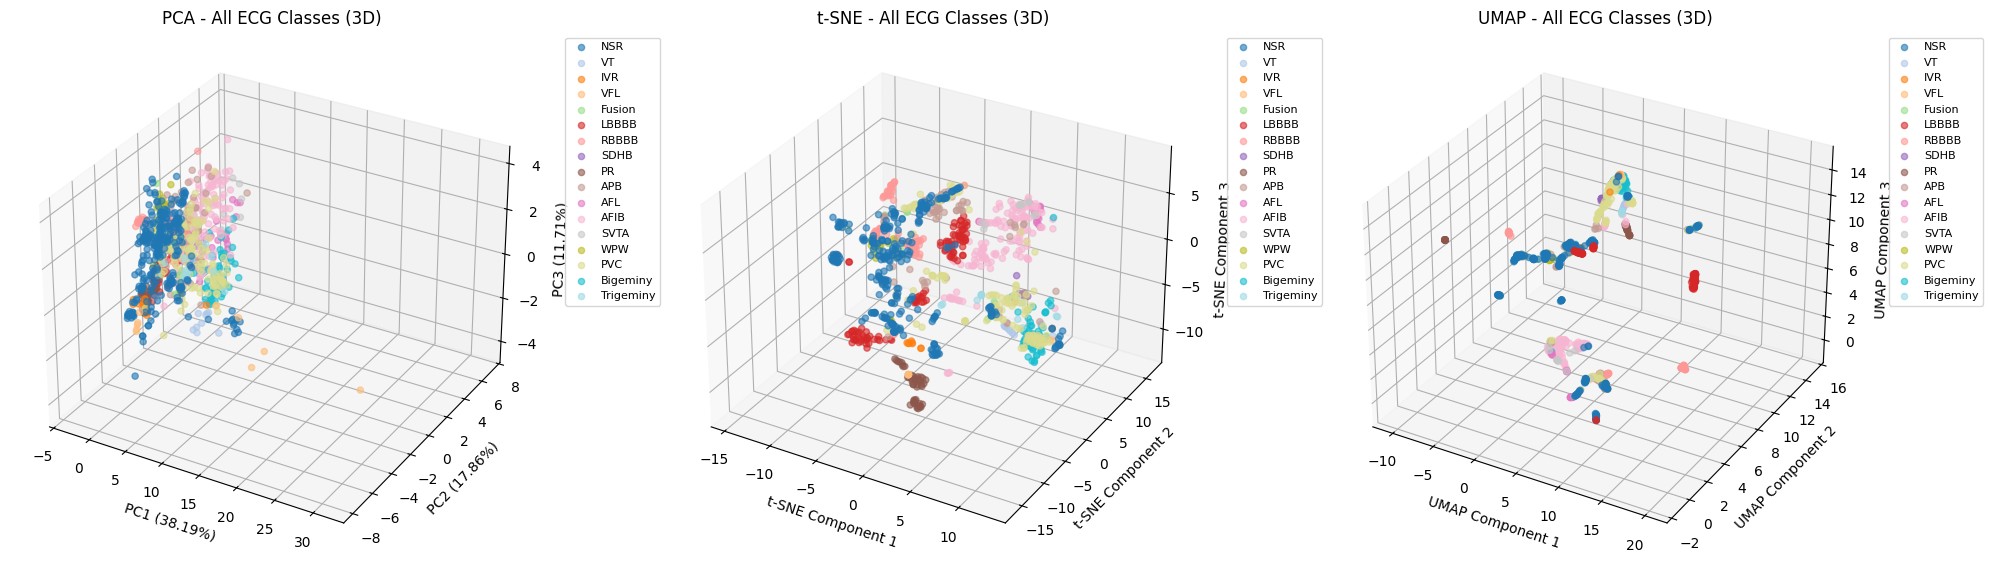


PCA total variance explained (3D): 67.76%
Individual components: PC1: 38.19%, PC2: 17.86%, PC3: 11.71%


In [24]:
unique_labels = y_final.unique()

# Apply dimensionality reduction techniques with 3 components
print("Applying 3D dimensionality reduction...")

# PCA with 3 components
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled_final)

# t-SNE with 3 components
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
X_tsne_3d = tsne_3d.fit_transform(X_scaled_final)

# UMAP with 3 components
umap_3d = UMAP(n_components=3, random_state=42)
X_umap_3d = umap_3d.fit_transform(X_scaled_final)

# Create 3D visualizations
fig = plt.figure(figsize=(20, 6))

# Get unique labels and colors
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

# PCA 3D plot
ax1 = fig.add_subplot(131, projection='3d')
for i, label in enumerate(unique_labels):
    mask = y == label
    ax1.scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], X_pca_3d[mask, 2], 
               c=[colors[i]], label=label, alpha=0.6, s=20)
ax1.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.2%})')
ax1.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.2%})')
ax1.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.2%})')
ax1.set_title('PCA - All ECG Classes (3D)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# t-SNE 3D plot
ax2 = fig.add_subplot(132, projection='3d')
for i, label in enumerate(unique_labels):
    mask = y == label
    ax2.scatter(X_tsne_3d[mask, 0], X_tsne_3d[mask, 1], X_tsne_3d[mask, 2], 
               c=[colors[i]], label=label, alpha=0.6, s=20)
ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')
ax2.set_zlabel('t-SNE Component 3')
ax2.set_title('t-SNE - All ECG Classes (3D)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# UMAP 3D plot
ax3 = fig.add_subplot(133, projection='3d')
for i, label in enumerate(unique_labels):
    mask = y == label
    ax3.scatter(X_umap_3d[mask, 0], X_umap_3d[mask, 1], X_umap_3d[mask, 2], 
               c=[colors[i]], label=label, alpha=0.6, s=20)
ax3.set_xlabel('UMAP Component 1')
ax3.set_ylabel('UMAP Component 2')
ax3.set_zlabel('UMAP Component 3')
ax3.set_title('UMAP - All ECG Classes (3D)')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

print(f"\nPCA total variance explained (3D): {sum(pca_3d.explained_variance_ratio_):.2%}")
print(f"Individual components: PC1: {pca_3d.explained_variance_ratio_[0]:.2%}, PC2: {pca_3d.explained_variance_ratio_[1]:.2%}, PC3: {pca_3d.explained_variance_ratio_[2]:.2%}")

## 7. Análisis de Separabilidad Final

### 7.1 Evaluación 3D con Características Avanzadas
Con el conjunto enriquecido de características clínicamente relevantes, evaluamos la capacidad de separación entre las diferentes clases de arritmias usando visualización tridimensional.

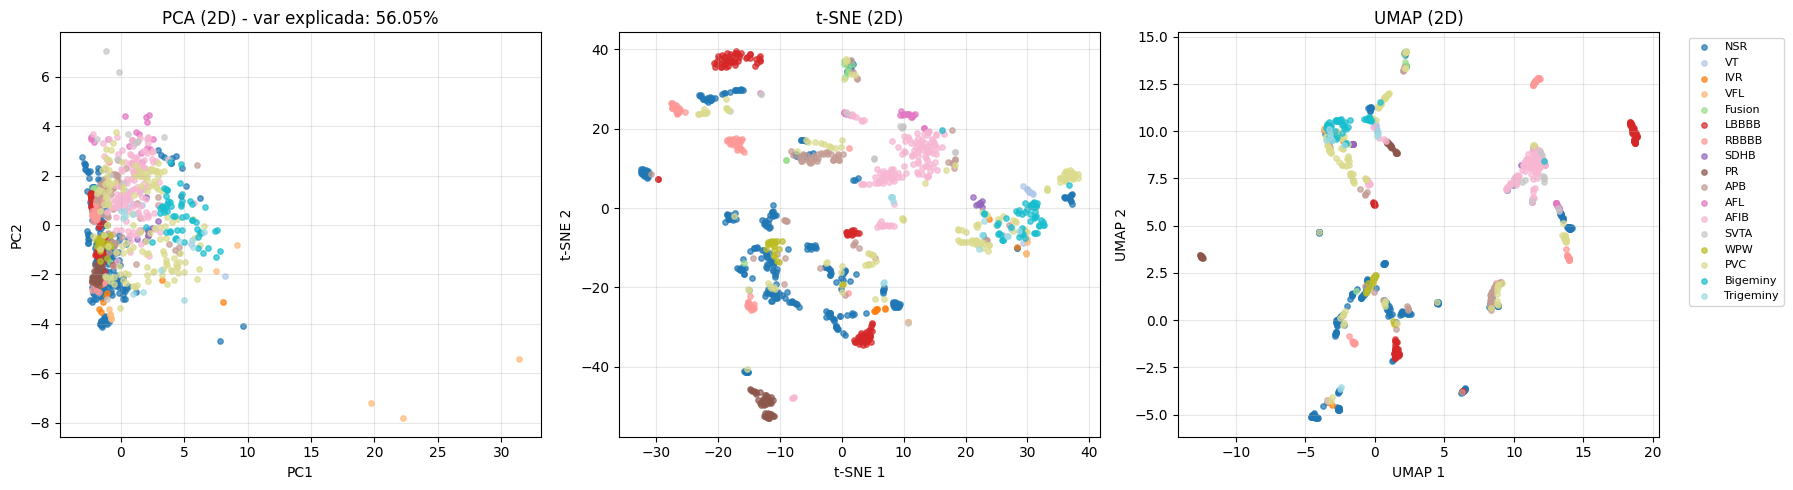

In [26]:
# Reducir a 2 dimensiones y plotear PCA, t-SNE, UMAP (usa X_scaled_final y y_final ya definidos)

pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled_final)

tsne_2 = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_2 = tsne_2.fit_transform(X_scaled_final)

umap_2 = UMAP(n_components=2, random_state=42)
X_umap_2 = umap_2.fit_transform(X_scaled_final)

# Preparar colores y etiquetas
unique_labels_2 = y_final.unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels_2)))

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, label in enumerate(unique_labels_2):
    mask = (y_final == label).to_numpy()
    axes[0].scatter(X_pca_2[mask, 0], X_pca_2[mask, 1], color=colors[i], label=label, alpha=0.7, s=15)
    axes[1].scatter(X_tsne_2[mask, 0], X_tsne_2[mask, 1], color=colors[i], label=label, alpha=0.7, s=15)
    axes[2].scatter(X_umap_2[mask, 0], X_umap_2[mask, 1], color=colors[i], label=label, alpha=0.7, s=15)

# Etiquetas y títulos
axes[0].set_title(f'PCA (2D) - var explicada: {sum(pca_2.explained_variance_ratio_):.2%}')
axes[0].set_xlabel('PC1'); axes[0].set_ylabel('PC2'); axes[0].grid(True, alpha=0.3)

axes[1].set_title('t-SNE (2D)')
axes[1].set_xlabel('t-SNE 1'); axes[1].set_ylabel('t-SNE 2'); axes[1].grid(True, alpha=0.3)

axes[2].set_title('UMAP (2D)')
axes[2].set_xlabel('UMAP 1'); axes[2].set_ylabel('UMAP 2'); axes[2].grid(True, alpha=0.3)

# Leyenda (una sola, afuera)
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

### 7.2 Comparación 2D Optimizada
Comparamos las técnicas de reducción de dimensionalidad en 2D usando las características avanzadas. Esta visualización nos permite:

1. **Evaluar la calidad de separación** entre clases
2. **Identificar posibles agrupamientos naturales** 
3. **Determinar la técnica más apropiada** para visualización o como paso previo a clasificación
4. **Detectar clases que pueden ser difíciles de distinguir**

#### Interpretación de Resultados:
- **Clusters bien separados** indican buena separabilidad para clasificación
- **Solapamiento significativo** sugiere la necesidad de características adicionales
- **Patrones distintivos** pueden revelar relaciones fisiológicas entre arritmias


>>> Entrenando y evaluando: Dummy(Majority)
              precision    recall  f1-score   support

        AFIB       0.00      0.00      0.00        27
         AFL       0.00      0.00      0.00         4
         APB       0.00      0.00      0.00        13
    Bigeminy       0.00      0.00      0.00        11
      Fusion       0.00      0.00      0.00         2
         IVR       0.00      0.00      0.00         2
       LBBBB       0.00      0.00      0.00        21
         NSR       0.28      1.00      0.44        57
          PR       0.00      0.00      0.00         9
         PVC       0.00      0.00      0.00        26
       RBBBB       0.00      0.00      0.00        12
        SDHB       0.00      0.00      0.00         2
        SVTA       0.00      0.00      0.00         3
   Trigeminy       0.00      0.00      0.00         3
         VFL       0.00      0.00      0.00         2
          VT       0.00      0.00      0.00         2
         WPW       0.00      0.00   

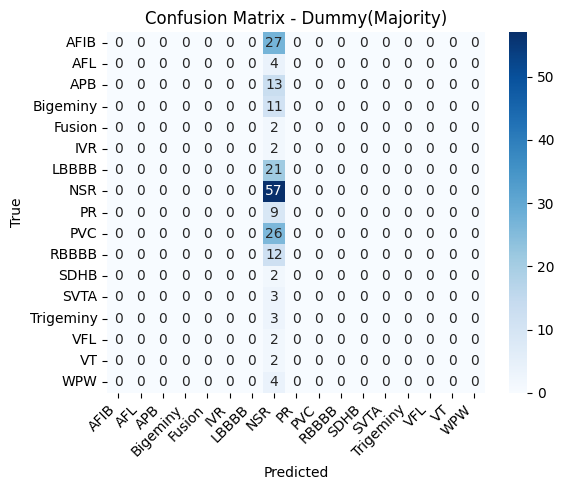


>>> Entrenando y evaluando: LogisticRegression
              precision    recall  f1-score   support

        AFIB       0.86      0.89      0.87        27
         AFL       1.00      0.50      0.67         4
         APB       0.71      0.38      0.50        13
    Bigeminy       0.82      0.82      0.82        11
      Fusion       0.00      0.00      0.00         2
         IVR       1.00      1.00      1.00         2
       LBBBB       0.86      0.90      0.88        21
         NSR       0.61      0.75      0.67        57
          PR       0.90      1.00      0.95         9
         PVC       0.58      0.54      0.56        26
       RBBBB       0.54      0.58      0.56        12
        SDHB       1.00      0.50      0.67         2
        SVTA       1.00      0.67      0.80         3
   Trigeminy       1.00      0.33      0.50         3
         VFL       0.67      1.00      0.80         2
          VT       1.00      0.50      0.67         2
         WPW       1.00      0.50

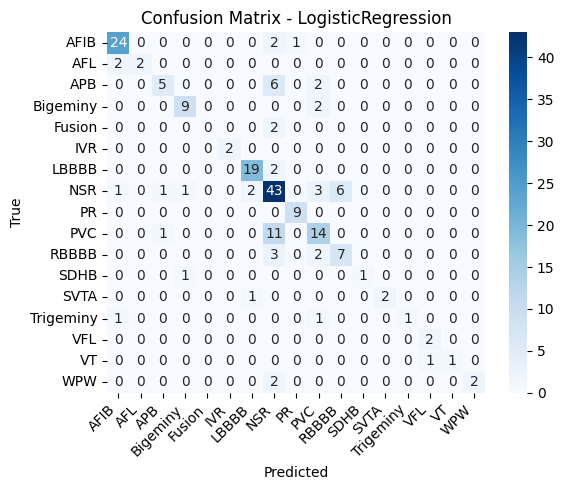


>>> Entrenando y evaluando: RandomForest
              precision    recall  f1-score   support

        AFIB       0.84      0.96      0.90        27
         AFL       1.00      0.75      0.86         4
         APB       0.70      0.54      0.61        13
    Bigeminy       1.00      0.82      0.90        11
      Fusion       1.00      0.50      0.67         2
         IVR       1.00      0.50      0.67         2
       LBBBB       1.00      1.00      1.00        21
         NSR       0.89      0.95      0.92        57
          PR       1.00      1.00      1.00         9
         PVC       0.78      0.81      0.79        26
       RBBBB       1.00      1.00      1.00        12
        SDHB       1.00      1.00      1.00         2
        SVTA       1.00      0.33      0.50         3
   Trigeminy       1.00      1.00      1.00         3
         VFL       0.50      1.00      0.67         2
          VT       1.00      0.50      0.67         2
         WPW       1.00      1.00      

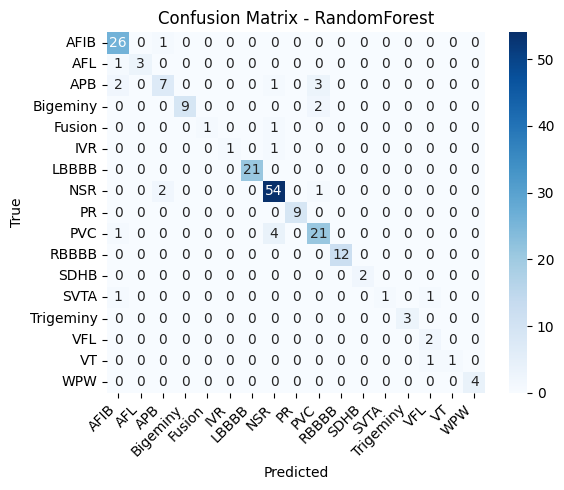


>>> Entrenando y evaluando: GradientBoosting
              precision    recall  f1-score   support

        AFIB       0.83      0.93      0.88        27
         AFL       1.00      0.50      0.67         4
         APB       0.80      0.62      0.70        13
    Bigeminy       0.78      0.64      0.70        11
      Fusion       1.00      0.50      0.67         2
         IVR       1.00      1.00      1.00         2
       LBBBB       0.91      1.00      0.95        21
         NSR       0.90      0.95      0.92        57
          PR       1.00      1.00      1.00         9
         PVC       0.66      0.81      0.72        26
       RBBBB       1.00      1.00      1.00        12
        SDHB       0.00      0.00      0.00         2
        SVTA       0.00      0.00      0.00         3
   Trigeminy       0.50      0.33      0.40         3
         VFL       0.67      1.00      0.80         2
          VT       1.00      0.50      0.67         2
         WPW       1.00      1.00  

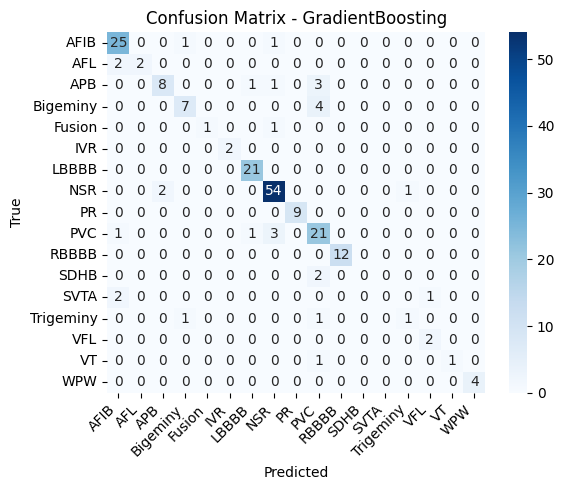


>>> Entrenando y evaluando: SVC-RBF
              precision    recall  f1-score   support

        AFIB       0.87      0.96      0.91        27
         AFL       1.00      0.75      0.86         4
         APB       0.70      0.54      0.61        13
    Bigeminy       1.00      0.91      0.95        11
      Fusion       0.00      0.00      0.00         2
         IVR       1.00      0.50      0.67         2
       LBBBB       0.84      1.00      0.91        21
         NSR       0.75      0.93      0.83        57
          PR       1.00      1.00      1.00         9
         PVC       0.85      0.65      0.74        26
       RBBBB       0.86      1.00      0.92        12
        SDHB       1.00      1.00      1.00         2
        SVTA       0.00      0.00      0.00         3
   Trigeminy       0.00      0.00      0.00         3
         VFL       0.50      1.00      0.67         2
          VT       1.00      0.50      0.67         2
         WPW       0.00      0.00      0.00 

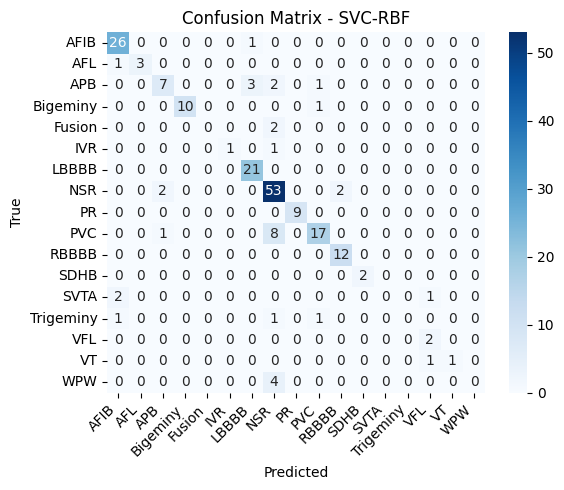


>>> Entrenando y evaluando: KNN
              precision    recall  f1-score   support

        AFIB       0.87      1.00      0.93        27
         AFL       1.00      0.75      0.86         4
         APB       0.73      0.62      0.67        13
    Bigeminy       0.92      1.00      0.96        11
      Fusion       0.00      0.00      0.00         2
         IVR       0.67      1.00      0.80         2
       LBBBB       0.91      1.00      0.95        21
         NSR       0.82      0.93      0.87        57
          PR       1.00      1.00      1.00         9
         PVC       0.83      0.58      0.68        26
       RBBBB       1.00      1.00      1.00        12
        SDHB       1.00      1.00      1.00         2
        SVTA       1.00      0.33      0.50         3
   Trigeminy       1.00      0.33      0.50         3
         VFL       0.50      1.00      0.67         2
          VT       1.00      0.50      0.67         2
         WPW       1.00      0.75      0.86     

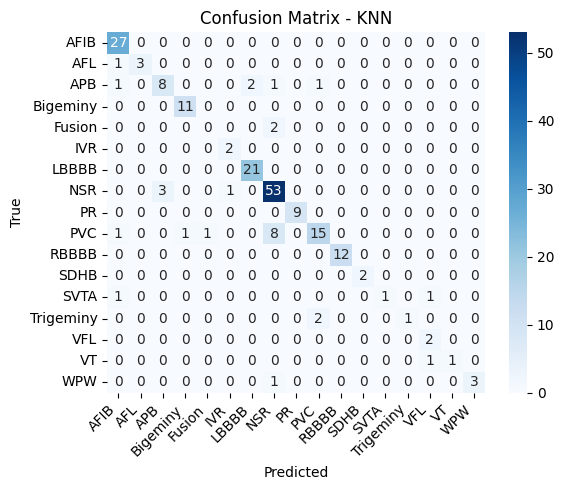

,accuracy,precision_macro,recall_macro,f1_macro,cv_f1_macro_mean,cv_f1_macro_std,roc_auc_macro
model,,,,,,,
RandomForest,0.885,0.923631,0.803412,0.831574,0.800771,0.041460,0.980099
KNN,0.855,0.837843,0.752282,0.759239,0.724513,0.035485,0.942667
GradientBoosting,0.850,0.767475,0.692122,0.710271,0.686618,0.056723,0.968532
LogisticRegression,0.715,0.796902,0.639566,0.681208,0.646469,0.034747,0.953071
SVC-RBF,0.820,0.668252,0.632011,0.631404,0.631715,0.028700,0.982568
Dummy(Majority),0.285,0.016765,0.058824,0.026093,0.025950,0.000175,0.500000



✅ Evaluación completada. Resumen guardado en 'classification_results_summary.csv'


In [27]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# Clasificadores múltiples y evaluación de métricas
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score)

# Variables existentes en el notebook:
# X_scaled_final, y_final, labels/unique_labels están disponibles

# Preparación de datos
X = X_scaled_final
y = y_final.to_numpy()
le = LabelEncoder()
y_enc = le.fit_transform(y)
n_classes = len(le.classes_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

# Definición de modelos a evaluar
models = {
    "Dummy(Majority)": DummyClassifier(strategy="most_frequent"),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "SVC-RBF": SVC(kernel="rbf", probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Evaluación
results = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Binarizar etiquetas para ROC-AUC multiclase
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

for name, model in models.items():
    print(f"\n>>> Entrenando y evaluando: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Scores clásicos
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

    # Cross-validated F1 macro sobre todo el dataset
    try:
        cv_scores = cross_val_score(model, X, y_enc, cv=cv, scoring="f1_macro", n_jobs=-1)
        cv_mean, cv_std = float(cv_scores.mean()), float(cv_scores.std())
    except Exception:
        cv_mean, cv_std = np.nan, np.nan

    # ROC-AUC (multiclase, macro) si es posible
    y_score = None
    try:
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)
        elif hasattr(model, "decision_function"):
            dec = model.decision_function(X_test)
            # ensure shape (n_samples, n_classes)
            if dec.ndim == 1 and n_classes == 2:
                y_score = np.vstack([1 - dec, dec]).T
            else:
                y_score = dec
    except Exception:
        y_score = None

    if y_score is not None:
        try:
            roc_auc = roc_auc_score(y_test_binarized, y_score, average="macro", multi_class="ovr")
        except Exception:
            roc_auc = np.nan
    else:
        roc_auc = np.nan

    # Guardar resultados
    results.append({
        "model": name,
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
        "cv_f1_macro_mean": cv_mean,
        "cv_f1_macro_std": cv_std,
        "roc_auc_macro": roc_auc
    })

    # Mostrar informe por clase y matriz de confusión
    print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred), zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Resumen de métricas en DataFrame
results_df = pd.DataFrame(results).set_index("model")
display(results_df.sort_values("f1_macro", ascending=False))

# Guardar resultados opcionalmente
results_df.to_csv("classification_results_summary.csv", index=True)
print("\n✅ Evaluación completada. Resumen guardado en 'classification_results_summary.csv'")

Extracting wavelet features from original 'data' ...
Created wavelet features dataframe: 1000 samples, 70 features
Features scaled shape: (1000, 69)
Applying PCA / t-SNE / UMAP (3D)...
Created wavelet features dataframe: 1000 samples, 70 features
Features scaled shape: (1000, 69)
Applying PCA / t-SNE / UMAP (3D)...


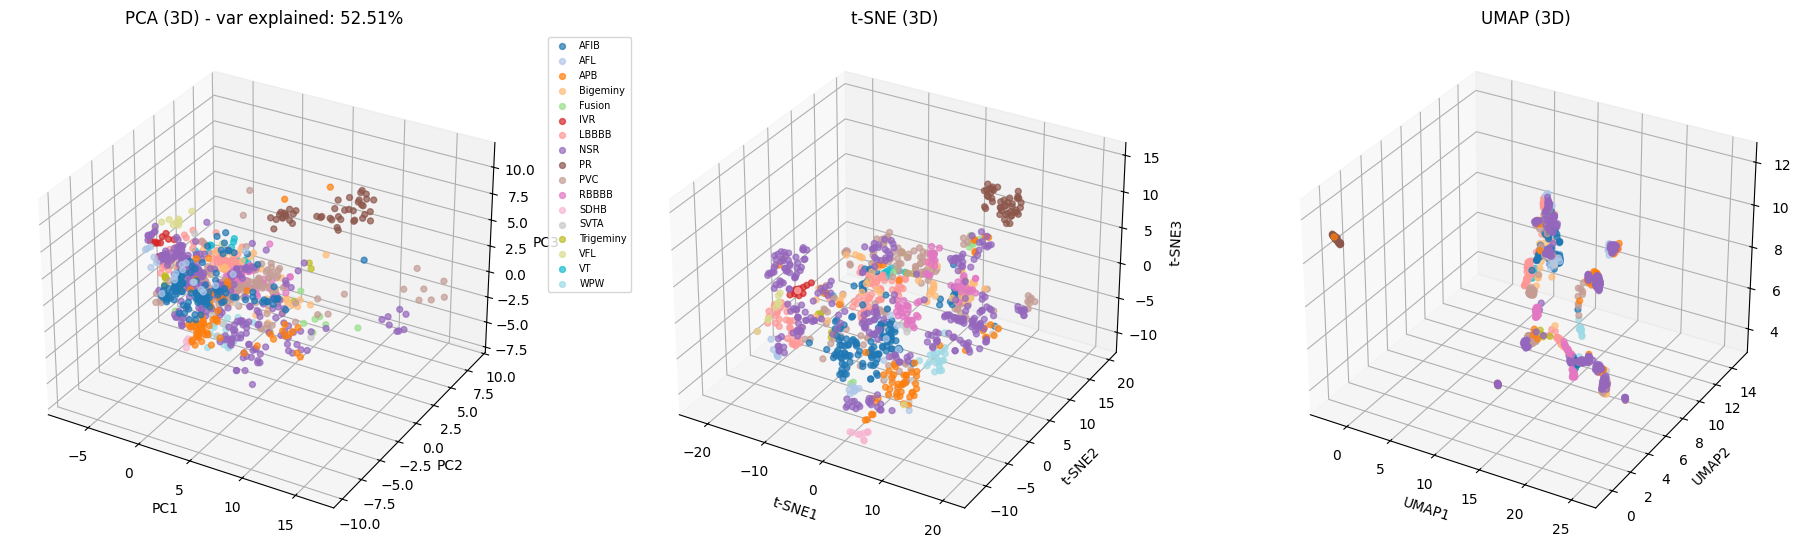

In [ ]:
import pywt

# Wavelet-based features -> dataset -> scaling -> 3D PCA/TSNE/UMAP visualization

def wavelet_features(signal, wavelet='db4', level=5):
    # compute multilevel DWT coefficients
    coeffs = pywt.wavedec(signal, wavelet=wavelet, level=level)
    feats = {}
    total_energy = 0.0
    energies = []
    # compute per-coefficient summary stats
    for i, c in enumerate(coeffs):
        name = f'cA{level}' if i == 0 else f'cD{level-(i-1)}'
        c = np.asarray(c, dtype=float)
        energy = np.sum(c**2)
        total_energy += energy
        energies.append((name, energy))
        s = pd.Series(c)
        feats.update({
            f'{name}_len': c.size,
            f'{name}_mean': float(s.mean()) if c.size else np.nan,
            f'{name}_std':  float(s.std(ddof=1)) if c.size>1 else np.nan,
            f'{name}_median': float(s.median()) if c.size else np.nan,
            f'{name}_min': float(s.min()) if c.size else np.nan,
            f'{name}_max': float(s.max()) if c.size else np.nan,
            f'{name}_ptp': float(s.max()-s.min()) if c.size else np.nan,
            f'{name}_skew': float(s.skew()) if c.size else np.nan,
            f'{name}_kurt': float(s.kurtosis()) if c.size else np.nan,
            f'{name}_energy': float(energy)
        })
    # relative energies
    if total_energy > 0:
        for name, e in energies:
            feats[f'{name}_rel_energy'] = float(e / total_energy)
    else:
        for name, e in energies:
            feats[f'{name}_rel_energy'] = np.nan

    # simple entropy of whole signal (approx)
    try:
        feats['signal_sampen'] = float(nk.entropy_sample(signal))
    except Exception:
        feats['signal_sampen'] = np.nan

    feats['signal_energy'] = float(np.sum(np.asarray(signal, dtype=float)**2))
    feats['signal_mean'] = float(np.mean(signal))
    feats['signal_std']  = float(np.std(signal, ddof=1)) if signal.size>1 else np.nan
    return feats

# Build dataset of wavelet features from original `data`
wave_feats = []
wave_labels = []

print("Extracting wavelet features from original 'data' ...")
for label in labels:
    class_signals = data[label]
    for sig in class_signals:
        try:
            wf = wavelet_features(sig, wavelet='db4', level=5)
            wave_feats.append(wf)
            wave_labels.append(label)
        except Exception as e:
            # skip problematic signals but continue
            continue

wave_df = pd.DataFrame(wave_feats)
wave_df['label'] = wave_labels
print(f"Created wavelet features dataframe: {wave_df.shape[0]} samples, {wave_df.shape[1]-1} features")

# Clean: drop columns with >50% NaN, then impute median
nan_pct = wave_df.isnull().mean() * 100
cols_drop = nan_pct[nan_pct > 50].index.tolist()
if cols_drop:
    wave_df = wave_df.drop(columns=cols_drop)
for col in wave_df.columns.drop('label'):
    if pd.api.types.is_numeric_dtype(wave_df[col]):
        wave_df[col] = wave_df[col].fillna(wave_df[col].median())

# Separate X,y and scale
X_wave = wave_df.drop('label', axis=1)
y_wave = wave_df['label'].to_numpy()
scaler_wave = StandardScaler()
X_wave_scaled = scaler_wave.fit_transform(X_wave)
print(f"Features scaled shape: {X_wave_scaled.shape}")

# Dimensionality reduction to 3 components
print("Applying PCA / t-SNE / UMAP (3D)...")
pca_w = PCA(n_components=3)
X_pca_w = pca_w.fit_transform(X_wave_scaled)

tsne_w = TSNE(n_components=3, random_state=42, perplexity=30)
X_tsne_w = tsne_w.fit_transform(X_wave_scaled)

umap_w = UMAP(n_components=3, random_state=42)
X_umap_w = umap_w.fit_transform(X_wave_scaled)

# 3D plotting
from mpl_toolkits.mplot3d import Axes3D  # available earlier but explicit for cell clarity
unique_lbls = np.unique(y_wave)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_lbls)))

fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(131, projection='3d')
for i, lab in enumerate(unique_lbls):
    mask = (y_wave == lab)
    ax1.scatter(X_pca_w[mask, 0], X_pca_w[mask, 1], X_pca_w[mask, 2],
                color=colors[i], label=lab, s=18, alpha=0.7)
ax1.set_title(f'PCA (3D) - var explained: {sum(pca_w.explained_variance_ratio_):.2%}')
ax1.set_xlabel('PC1'); ax1.set_ylabel('PC2'); ax1.set_zlabel('PC3')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)

ax2 = fig.add_subplot(132, projection='3d')
for i, lab in enumerate(unique_lbls):
    mask = (y_wave == lab)
    ax2.scatter(X_tsne_w[mask, 0], X_tsne_w[mask, 1], X_tsne_w[mask, 2],
                color=colors[i], label=lab, s=18, alpha=0.7)
ax2.set_title('t-SNE (3D)')
ax2.set_xlabel('t-SNE1'); ax2.set_ylabel('t-SNE2'); ax2.set_zlabel('t-SNE3')

ax3 = fig.add_subplot(133, projection='3d')
for i, lab in enumerate(unique_lbls):
    mask = (y_wave == lab)
    ax3.scatter(X_umap_w[mask, 0], X_umap_w[mask, 1], X_umap_w[mask, 2],
                color=colors[i], label=lab, s=18, alpha=0.7)
ax3.set_title('UMAP (3D)')
ax3.set_xlabel('UMAP1'); ax3.set_ylabel('UMAP2'); ax3.set_zlabel('UMAP3')

plt.tight_layout()
plt.show()

## 9. Evaluación de Modelos de Machine Learning

### 9.1 Clasificación con Características Wavelet

En esta sección evaluamos diferentes algoritmos de machine learning utilizando las características extraídas con transformada wavelet. La evaluación incluye:

#### Modelos Evaluados:
- **Dummy Classifier**: Baseline que predice la clase mayoritaria
- **Logistic Regression**: Modelo lineal con regularización
- **Random Forest**: Ensamble de árboles de decisión
- **Gradient Boosting**: Boosting secuencial de modelos débiles  
- **SVM-RBF**: Máquinas de soporte vectorial con kernel radial
- **K-Nearest Neighbors**: Clasificación basada en vecindad

#### Métricas de Evaluación:
- **Accuracy**: Proporción de predicciones correctas
- **Precision/Recall/F1-Score macro**: Métricas balanceadas para clases múltiples
- **Cross-Validation**: Validación cruzada estratificada de 5 pliegues
- **ROC-AUC**: Área bajo la curva ROC para evaluación multiclase
- **Confusion Matrix**: Matriz de confusión para análisis detallado por clase


>>> Entrenando y evaluando: Dummy(Majority)
              precision    recall  f1-score   support

        AFIB       0.00      0.00      0.00        27
         AFL       0.00      0.00      0.00         4
         APB       0.00      0.00      0.00        13
    Bigeminy       0.00      0.00      0.00        11
      Fusion       0.00      0.00      0.00         2
         IVR       0.00      0.00      0.00         2
       LBBBB       0.00      0.00      0.00        21
         NSR       0.28      1.00      0.44        57
          PR       0.00      0.00      0.00         9
         PVC       0.00      0.00      0.00        26
       RBBBB       0.00      0.00      0.00        12
        SDHB       0.00      0.00      0.00         2
        SVTA       0.00      0.00      0.00         3
   Trigeminy       0.00      0.00      0.00         3
         VFL       0.00      0.00      0.00         2
          VT       0.00      0.00      0.00         2
         WPW       0.00      0.00   

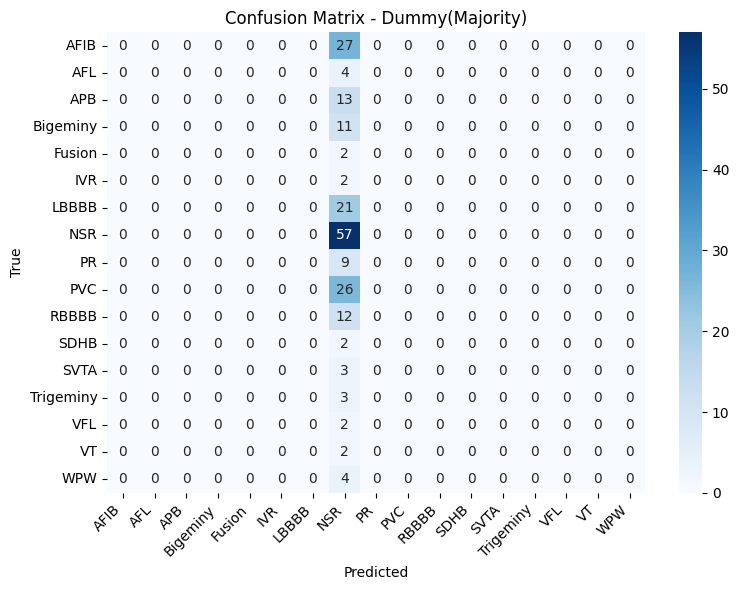


>>> Entrenando y evaluando: LogisticRegression
              precision    recall  f1-score   support

        AFIB       0.87      0.96      0.91        27
         AFL       1.00      0.75      0.86         4
         APB       0.47      0.54      0.50        13
    Bigeminy       0.86      0.55      0.67        11
      Fusion       0.00      0.00      0.00         2
         IVR       1.00      1.00      1.00         2
       LBBBB       0.76      0.76      0.76        21
         NSR       0.84      0.93      0.88        57
          PR       1.00      1.00      1.00         9
         PVC       0.78      0.81      0.79        26
       RBBBB       0.92      0.92      0.92        12
        SDHB       1.00      1.00      1.00         2
        SVTA       0.00      0.00      0.00         3
   Trigeminy       0.00      0.00      0.00         3
         VFL       1.00      1.00      1.00         2
          VT       0.50      0.50      0.50         2
         WPW       1.00      1.00

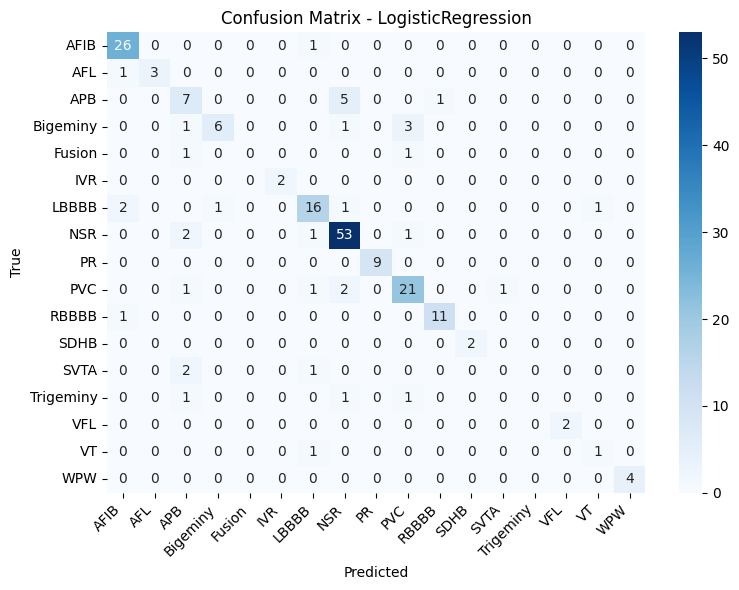


>>> Entrenando y evaluando: RandomForest
              precision    recall  f1-score   support

        AFIB       0.89      0.93      0.91        27
         AFL       1.00      0.75      0.86         4
         APB       0.89      0.62      0.73        13
    Bigeminy       0.77      0.91      0.83        11
      Fusion       1.00      0.50      0.67         2
         IVR       1.00      1.00      1.00         2
       LBBBB       0.88      1.00      0.93        21
         NSR       0.90      1.00      0.95        57
          PR       1.00      1.00      1.00         9
         PVC       0.88      0.88      0.88        26
       RBBBB       1.00      1.00      1.00        12
        SDHB       1.00      1.00      1.00         2
        SVTA       1.00      0.33      0.50         3
   Trigeminy       0.00      0.00      0.00         3
         VFL       1.00      1.00      1.00         2
          VT       1.00      0.50      0.67         2
         WPW       1.00      1.00      

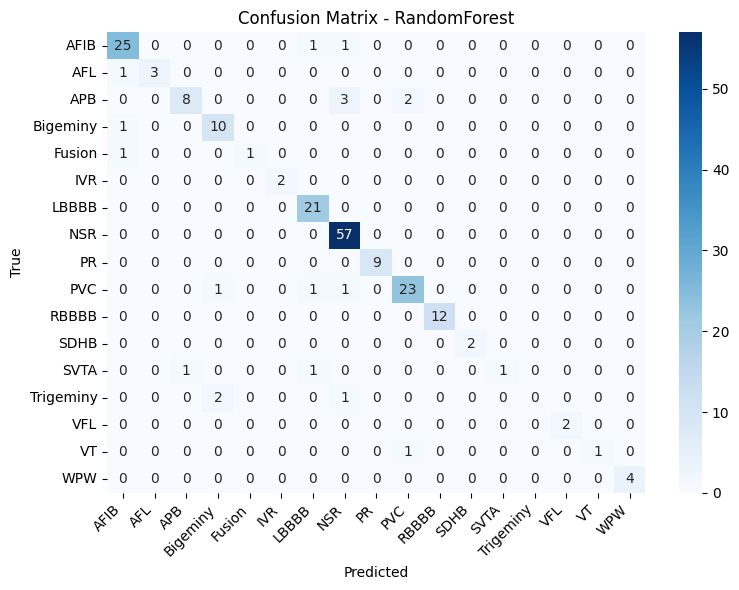


>>> Entrenando y evaluando: GradientBoosting
              precision    recall  f1-score   support

        AFIB       0.81      0.96      0.88        27
         AFL       1.00      0.75      0.86         4
         APB       0.80      0.62      0.70        13
    Bigeminy       0.80      0.73      0.76        11
      Fusion       0.00      0.00      0.00         2
         IVR       0.33      0.50      0.40         2
       LBBBB       0.91      0.95      0.93        21
         NSR       0.83      0.95      0.89        57
          PR       1.00      1.00      1.00         9
         PVC       0.78      0.81      0.79        26
       RBBBB       1.00      0.67      0.80        12
        SDHB       1.00      1.00      1.00         2
        SVTA       0.50      0.33      0.40         3
   Trigeminy       1.00      0.33      0.50         3
         VFL       1.00      1.00      1.00         2
          VT       0.00      0.00      0.00         2
         WPW       0.50      0.25  

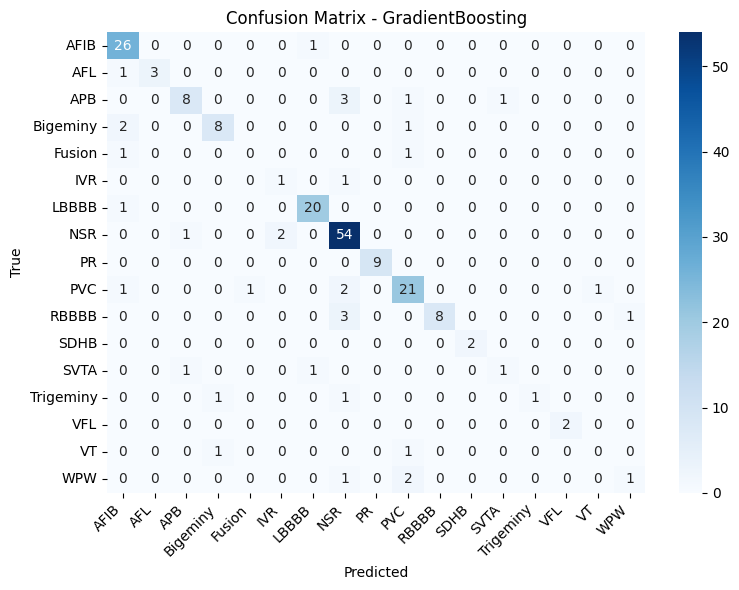


>>> Entrenando y evaluando: SVC-RBF
              precision    recall  f1-score   support

        AFIB       0.79      0.96      0.87        27
         AFL       1.00      0.75      0.86         4
         APB       0.86      0.46      0.60        13
    Bigeminy       0.67      0.73      0.70        11
      Fusion       0.50      0.50      0.50         2
         IVR       1.00      1.00      1.00         2
       LBBBB       0.76      0.76      0.76        21
         NSR       0.82      0.95      0.88        57
          PR       1.00      1.00      1.00         9
         PVC       0.84      0.81      0.82        26
       RBBBB       1.00      1.00      1.00        12
        SDHB       1.00      1.00      1.00         2
        SVTA       0.00      0.00      0.00         3
   Trigeminy       0.00      0.00      0.00         3
         VFL       1.00      1.00      1.00         2
          VT       1.00      0.50      0.67         2
         WPW       1.00      0.75      0.86 

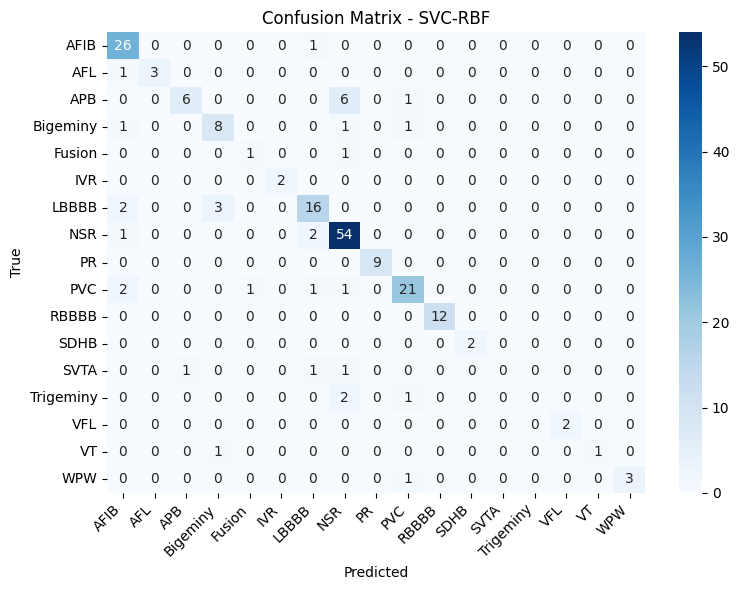


>>> Entrenando y evaluando: KNN
              precision    recall  f1-score   support

        AFIB       0.73      1.00      0.84        27
         AFL       1.00      0.50      0.67         4
         APB       0.78      0.54      0.64        13
    Bigeminy       0.64      0.82      0.72        11
      Fusion       0.25      0.50      0.33         2
         IVR       0.67      1.00      0.80         2
       LBBBB       0.80      0.95      0.87        21
         NSR       0.85      0.88      0.86        57
          PR       0.90      1.00      0.95         9
         PVC       0.93      0.54      0.68        26
       RBBBB       1.00      1.00      1.00        12
        SDHB       1.00      1.00      1.00         2
        SVTA       0.00      0.00      0.00         3
   Trigeminy       0.00      0.00      0.00         3
         VFL       1.00      1.00      1.00         2
          VT       1.00      1.00      1.00         2
         WPW       1.00      1.00      1.00     

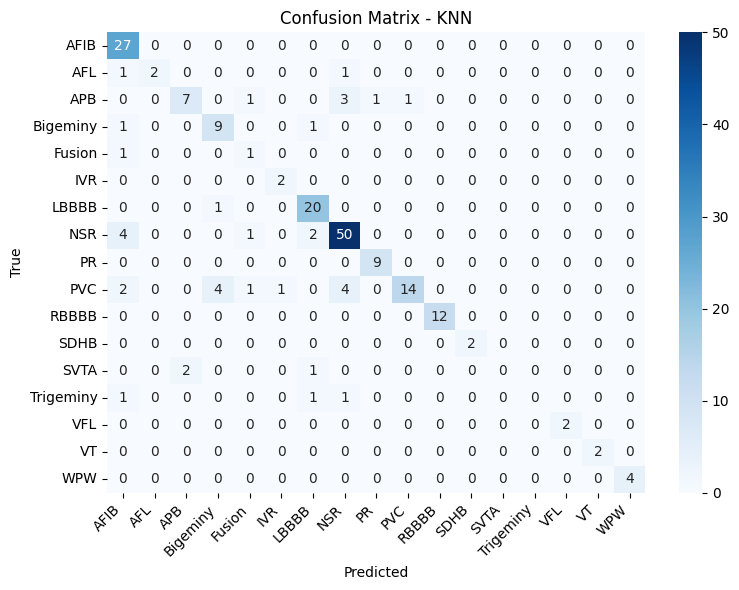

,accuracy,precision_macro,recall_macro,f1_macro,cv_f1_macro_mean,cv_f1_macro_std,roc_auc_macro
model,,,,,,,
RandomForest,0.905,0.895021,0.789315,0.819301,0.783696,0.052613,0.977987
SVC-RBF,0.830,0.778340,0.715808,0.735691,0.671760,0.060642,0.961622
KNN,0.815,0.738107,0.748511,0.727179,0.715273,0.023583,0.966326
LogisticRegression,0.815,0.705182,0.688998,0.693556,0.679089,0.042295,0.957878
GradientBoosting,0.825,0.721381,0.638023,0.661019,0.686864,0.051767,0.958436
Dummy(Majority),0.285,0.016765,0.058824,0.026093,0.025950,0.000175,0.500000



✅ Evaluación wavelet completada. Resumen guardado en 'wavelet_classification_results_summary.csv'


In [32]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Clasificación usando features wavelet (X_wave_scaled, y_wave ya definidos en el notebook)

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score)

# Preparar datos
le_wave = LabelEncoder()
y_wave_enc = le_wave.fit_transform(y_wave)            # y_wave: array de etiquetas (strings)
n_classes_wave = len(le_wave.classes_)

Xw = X_wave_scaled                                     # X_wave_scaled ya definido
yw = y_wave_enc

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
    Xw, yw, test_size=0.2, stratify=yw, random_state=42
)

# Modelos a evaluar
models_wave = {
    "Dummy(Majority)": DummyClassifier(strategy="most_frequent"),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "SVC-RBF": SVC(kernel="rbf", probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_test_binarized = label_binarize(yw_test, classes=np.arange(n_classes_wave))

results_wave = []

for name, model in models_wave.items():
    print(f"\n>>> Entrenando y evaluando: {name}")
    model.fit(Xw_train, yw_train)
    y_pred = model.predict(Xw_test)

    acc = accuracy_score(yw_test, y_pred)
    prec = precision_score(yw_test, y_pred, average="macro", zero_division=0)
    rec = recall_score(yw_test, y_pred, average="macro", zero_division=0)
    f1 = f1_score(yw_test, y_pred, average="macro", zero_division=0)

    # Cross-validated F1 macro sobre todo el dataset
    try:
        cv_scores = cross_val_score(model, Xw, yw, cv=cv, scoring="f1_macro", n_jobs=-1)
        cv_mean, cv_std = float(cv_scores.mean()), float(cv_scores.std())
    except Exception:
        cv_mean, cv_std = np.nan, np.nan

    # ROC-AUC multiclase (macro) si es posible
    y_score = None
    try:
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(Xw_test)
        elif hasattr(model, "decision_function"):
            dec = model.decision_function(Xw_test)
            if dec.ndim == 1 and n_classes_wave == 2:
                y_score = np.vstack([1 - dec, dec]).T
            else:
                y_score = dec
    except Exception:
        y_score = None

    if y_score is not None:
        try:
            roc_auc = roc_auc_score(y_test_binarized, y_score, average="macro", multi_class="ovr")
        except Exception:
            roc_auc = np.nan
    else:
        roc_auc = np.nan

    # Guardar resultados
    results_wave.append({
        "model": name,
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1,
        "cv_f1_macro_mean": cv_mean,
        "cv_f1_macro_std": cv_std,
        "roc_auc_macro": roc_auc
    })

    # Mostrar informe y matriz de confusión
    print(classification_report(le_wave.inverse_transform(yw_test), le_wave.inverse_transform(y_pred), zero_division=0))
    cm = confusion_matrix(yw_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le_wave.classes_, yticklabels=le_wave.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Resumen de métricas
results_wave_df = pd.DataFrame(results_wave).set_index("model")
display(results_wave_df.sort_values("f1_macro", ascending=False))

# Guardar resumen
results_wave_df.to_csv("wavelet_classification_results_summary.csv")
print("\n✅ Evaluación wavelet completada. Resumen guardado en 'wavelet_classification_results_summary.csv'")